# Remaining Useful Life Prediction
Documentation: https://developer.ibm.com/tutorials/awb-foundation-model-time-series-forecasting/

In [614]:
!git clone "https://github.com/ibm-granite/granite-tsfm.git"
#%cd granite-tsfm
#!pip install ".[notebooks]"
#%cd ../


fatal: destination path 'granite-tsfm' already exists and is not an empty directory.


In [615]:
# Core libraries
import os
import math
import tempfile
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# TSFM libraries
from tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm_public.toolkit.callbacks import TrackingCallback
from tsfm_public import (
    TimeSeriesPreprocessor,
    TinyTimeMixerForPrediction,
    TrackingCallback,
    count_parameters,
    get_datasets,
)

# TSFM Toolkit libraries
from tsfm_public.toolkit.util import select_by_index
from tsfm_public.toolkit.time_series_forecasting_pipeline import TimeSeriesForecastingPipeline
from tsfm_public.toolkit.visualization import plot_ts_forecasting

# Weights and Biases (WANB) API Key:
# 55786691f5bf98d3d3c2974925c51b1e1622d1d3

In [616]:
# Load datasets
with open('../data/processed_data_pickle_files_with_smoothing/test_data_no_batches.pkl', 'rb') as file:
    test_df = pickle.load(file)

with open('../data/processed_data_pickle_files_with_smoothing/test_data_no_batches.pkl', 'rb') as file:
    train_df = pickle.load(file)

# Ensure data are dataframes
if not isinstance(test_df, pd.DataFrame):
    raise ValueError("Loaded data is not a pandas DataFrame.")

if not isinstance(train_df, pd.DataFrame):
    raise ValueError("Loaded data is not a pandas DataFrame.")

column_names = ['unit_number', 'sensor_2', 'sensor_3', 'sensor_4',
       'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_15', 'sensor_17', 'sensor_20',
       'sensor_21']

train_df.columns = column_names
train_df.columns = column_names

In [617]:
# FOR DEVELOPMENT - FILTER TO 5 UNITS
unit_filter = 5
#train_df = train_df[train_df['unit_number'] < (unit_filter + 1)]

In [618]:
# Add RUL values to the train_df dataframe (unknown for test_df)
train_df['RUL'] = train_df.groupby('unit_number')['unit_number'].transform(lambda x: np.arange(len(x), 0, -1))
#test_df['RUL'] = test_df.groupby('unit_number')['unit_number'].transform(lambda x: np.arange(len(x), 0, -1))

In [619]:
print(train_df.head(20))

    unit_number  sensor_2  sensor_3  sensor_4  sensor_6  sensor_7  sensor_8  \
0           1.0  1.922208 -0.904665 -1.228605  0.495998  0.292745 -0.659857   
1           1.0  0.754317 -0.650760 -1.324650  0.495998  0.697198 -0.791728   
2           1.0 -0.057943 -0.468470 -1.344393  0.495998  0.957741 -0.856090   
3           1.0 -0.716104 -0.323225 -1.328357  0.495998  1.156672 -0.895388   
4           1.0 -1.011783 -0.272023 -1.225044  0.495998  1.211535 -0.880535   
5           1.0 -1.016215 -0.309541 -1.045663  0.495998  1.152273 -0.831335   
6           1.0 -0.860066 -0.412481 -0.818333  0.495998  1.033067 -0.776875   
7           1.0 -0.615236 -0.551412 -0.579687  0.495998  0.890446 -0.742218   
8           1.0 -0.365642 -0.685458 -0.371569  0.495998  0.763754 -0.746241   
9           1.0 -0.182241 -0.782296 -0.218792  0.495998  0.680395 -0.792037   
10          1.0 -0.089516 -0.846035 -0.159361  0.495998  0.645641 -0.872490   
11          1.0 -0.092452 -0.905724 -0.220310  0.495

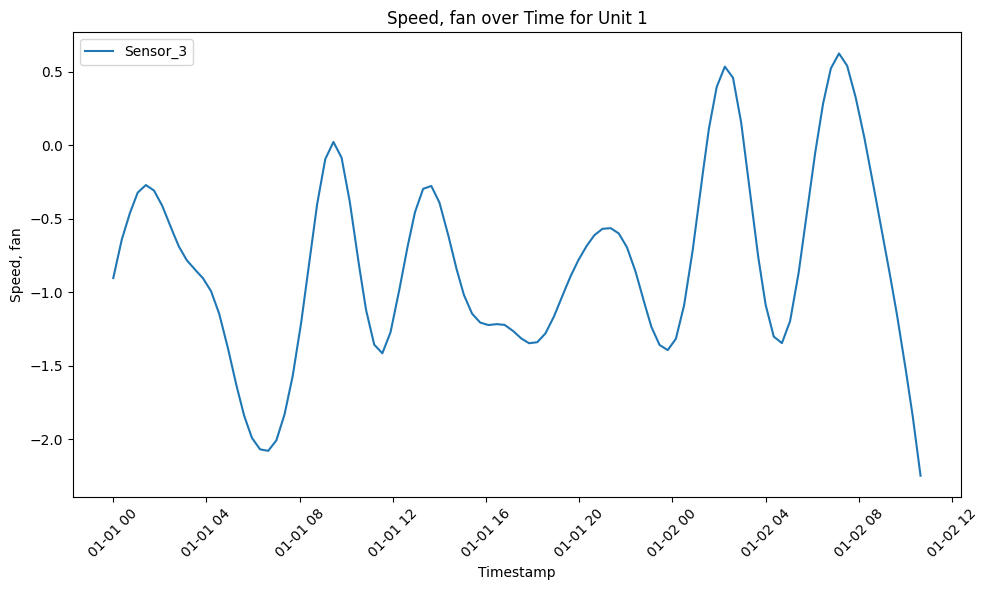

In [620]:
# Step 1 & 2: Efficiently add empty rows and timestamp for each unit_number
def expand_and_add_timestamp(df, num_empty_rows=20, start_date='2023-01-01'):
    dfs = []
    for unit_num, group in df.groupby('unit_number'):
        N = len(group)
        total_rows = N + (N - 1) * num_empty_rows
        # Create timestamps starting at midnight for each unit_number
        timestamps = pd.date_range(start=start_date, periods=total_rows, freq='min')
        # Create an empty DataFrame with timestamps
        expanded_group = pd.DataFrame({'timestamp': timestamps})
        # Calculate positions to insert the original data
        positions = np.arange(N) * (num_empty_rows + 1)
        # Assign unit_number to the expanded DataFrame
        expanded_group['unit_number'] = unit_num
        # Insert the original data into the correct positions
        expanded_group.loc[positions, group.columns] = group.values
        dfs.append(expanded_group)
    expanded_df = pd.concat(dfs, ignore_index=True)
    return expanded_df

# Step 3: Interpolate the missing values for each unit_number
def interpolate_missing_values(df):
    df = df.set_index(['unit_number', 'timestamp'])
    df = df.interpolate(method='linear')
    df = df.reset_index()
    return df


# Apply the steps to train_df
train_df = expand_and_add_timestamp(train_df)
train_df = interpolate_missing_values(train_df)

# Step 4: Plot 'Speed, fan' for unit_number = 1 over timestamp column
unit_1_data = train_df[train_df['unit_number'] == 1]
plt.figure(figsize=(10, 6))
plt.plot(unit_1_data['timestamp'], unit_1_data['sensor_3'], label='Sensor_3')
plt.xlabel('Timestamp')
plt.ylabel('Speed, fan')
plt.title('Speed, fan over Time for Unit 1')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [621]:
# Refine dataset
train_df = train_df.dropna()
train_df.columns

Index(['unit_number', 'timestamp', 'sensor_2', 'sensor_3', 'sensor_4',
       'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_15', 'sensor_17', 'sensor_20',
       'sensor_21', 'RUL'],
      dtype='object')

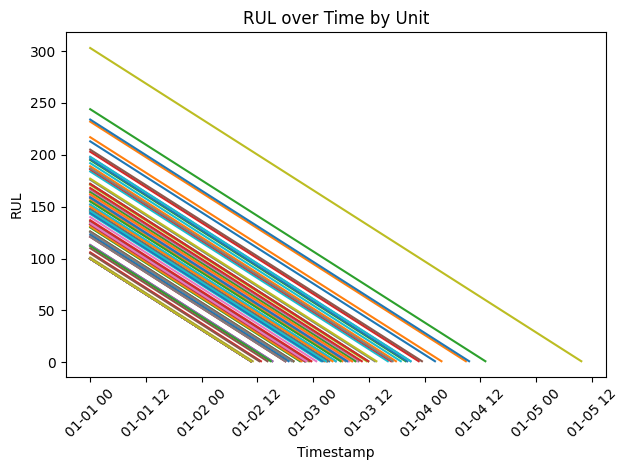

In [622]:
# Plot RUL over time for each unit in the dataset

# Loop through each unique unit number and plot separately
for unit in train_df['unit_number'].unique():
    unit_data = train_df[train_df['unit_number'] == unit]
    plt.plot(unit_data['timestamp'], unit_data['RUL'], label=f'Unit {unit}')

# Add labels and title
plt.xlabel('Timestamp')
plt.ylabel('RUL')
plt.title('RUL over Time by Unit')
plt.xticks(rotation=45)
#plt.legend()
plt.tight_layout()
plt.show()


# Forecasting

In [623]:
# Generate train/validation/test split configurations for each unit number in the dataset.
def generate_split_configs(input_df, context_length, unit_numbers=None):

    # If no unit numbers provided, get all unique unit numbers from the data
    if unit_numbers is None:
        unit_numbers = train_df['unit_number'].unique()

    split_configs = {}

    for unit in unit_numbers:
        # Filter data for current unit
        unit_data = input_df[input_df['unit_number'] == unit]
        #unit_data = unit_data.reset_index(drop=True)
        data_length = len(unit_data)

        # Calculate indices for train split (0 to 80%)
        train_start_index = 0
        train_end_index = round(data_length * 0.8)

        # Calculate indices for validation split (80% to 90%)
        # Shift back by context length to ensure first evaluation timestamp follows training data
        eval_start_index = round(data_length * 0.8) - context_length
        eval_end_index = round(data_length * 0.9)

        # Calculate indices for test split (90% to end)
        test_start_index = round(data_length * 0.9) - context_length
        test_end_index = data_length - 1

        # Create split configuration for current unit
        split_configs[unit] = {
            "train": [train_start_index, train_end_index],
            "valid": [eval_start_index, eval_end_index],
            "test": [test_start_index, test_end_index]
        }

    return list(split_configs.values())

In [624]:
# Function to determine actual vs predicted values
def compare_forecast(forecast, date_col, prediction_col, actual_col, delta):
  comparisons = pd.DataFrame()
  comparisons[date_col] = forecast[date_col]
  actual = []
  pred = []

  for i in range(len(forecast)):
    pred.append(forecast[prediction_col].values[i][delta - 1]) # prediction for next day
    actual.append(forecast[actual_col].values[i][delta - 1])

  comparisons['actual'] = actual
  comparisons['pred'] = pred

  return comparisons

In [625]:
print(train_df.columns)

Index(['unit_number', 'timestamp', 'sensor_2', 'sensor_3', 'sensor_4',
       'sensor_6', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11',
       'sensor_12', 'sensor_13', 'sensor_15', 'sensor_17', 'sensor_20',
       'sensor_21', 'RUL'],
      dtype='object')


In [626]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# Forecasting parameters
context_length = 512 # TTM can use 512 time points into the past
forecast_length = 96 # TTM can predict 96 time points into the future
fewshot_fraction = 0.05 # 5% of the data can be used for few-shot
prediction_filter = 24 # Filter this many predicted time points

# Set column parameters
timestamp_column = "timestamp"
target_columns = ["sensor_2"]
observable_columns = train_df.columns[3:-1]   # Exclude 'unit_number' and 'RUL' columns

# Set up Column Specifiers and Preprocessor
column_specifiers = {
    "timestamp_column": timestamp_column,
    "target_columns": target_columns,
    "observable_columns": observable_columns
}

  0%|          | 0/78 [00:00<?, ?it/s]

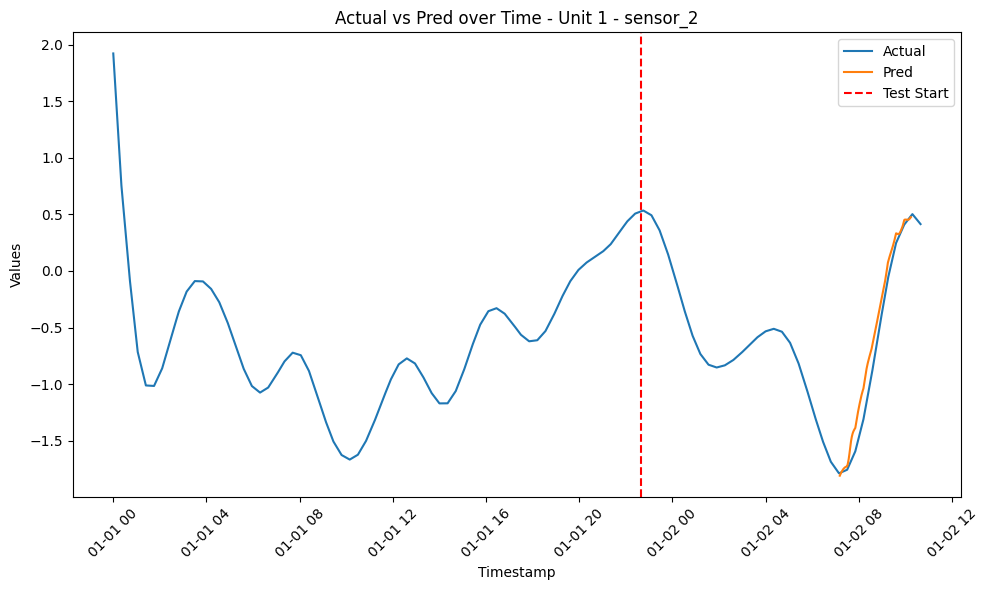

RMSE for Unit 1 - sensor_2: 0.18005526787497583


  0%|          | 0/78 [00:00<?, ?it/s]

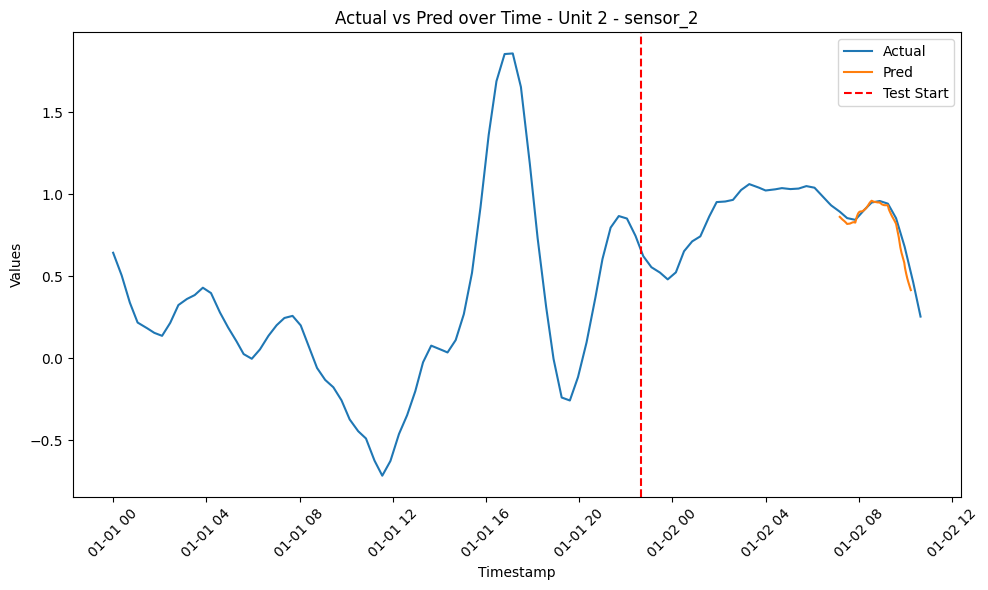

RMSE for Unit 2 - sensor_2: 0.08068414067644297


  0%|          | 0/85 [00:00<?, ?it/s]

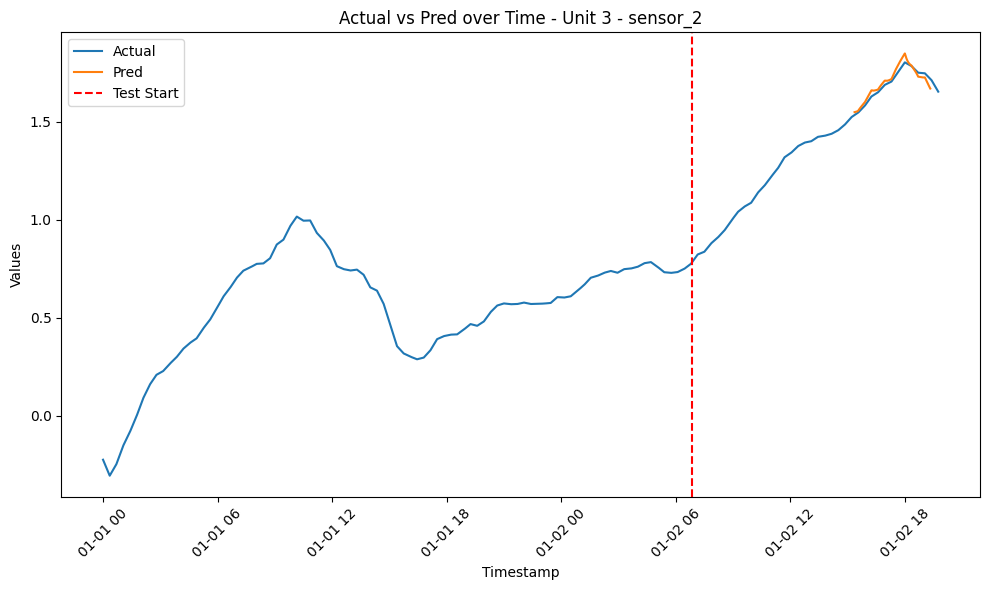

RMSE for Unit 3 - sensor_2: 0.02697404038805353


  0%|          | 0/80 [00:00<?, ?it/s]

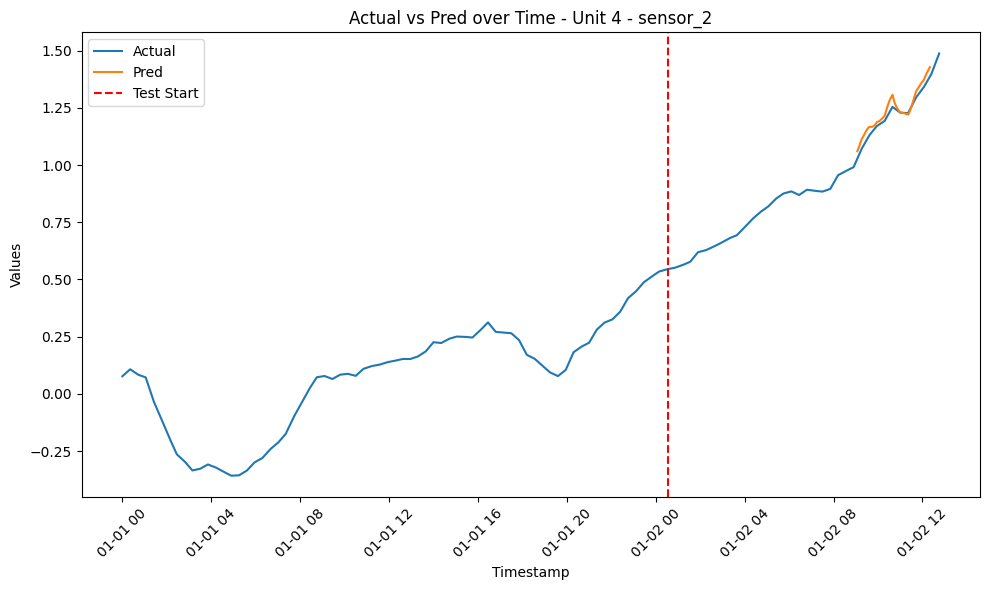

RMSE for Unit 4 - sensor_2: 0.03955141795554141


  0%|          | 0/78 [00:00<?, ?it/s]

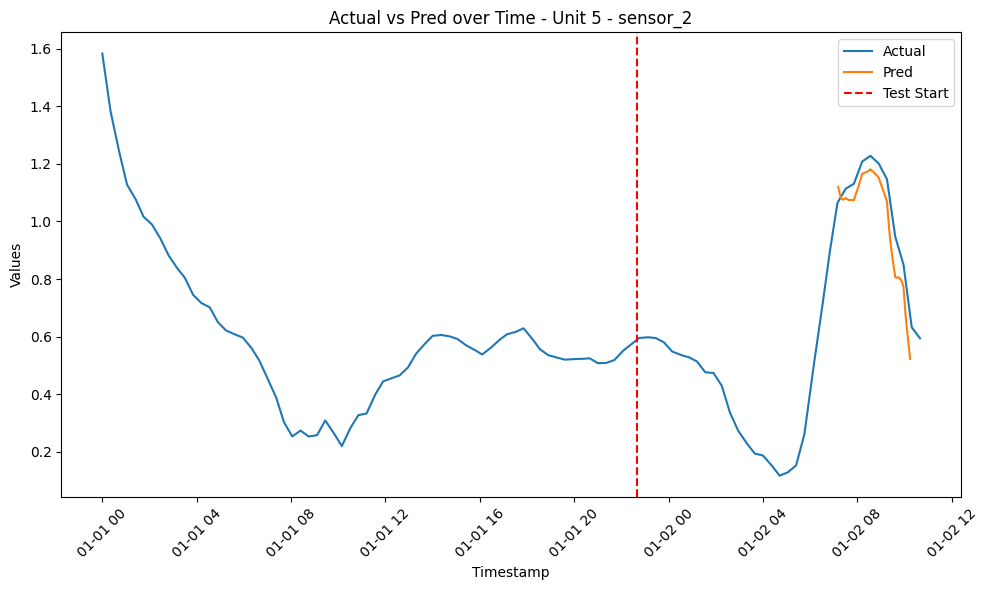

RMSE for Unit 5 - sensor_2: 0.07750108773456874


  0%|          | 0/80 [00:00<?, ?it/s]

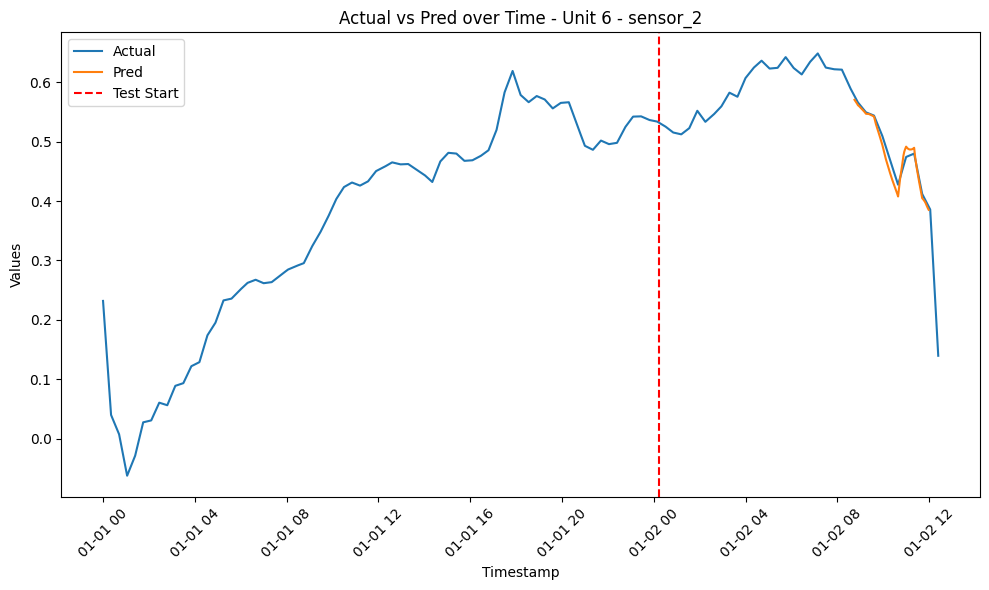

RMSE for Unit 6 - sensor_2: 0.05821255093830461


  0%|          | 0/94 [00:00<?, ?it/s]

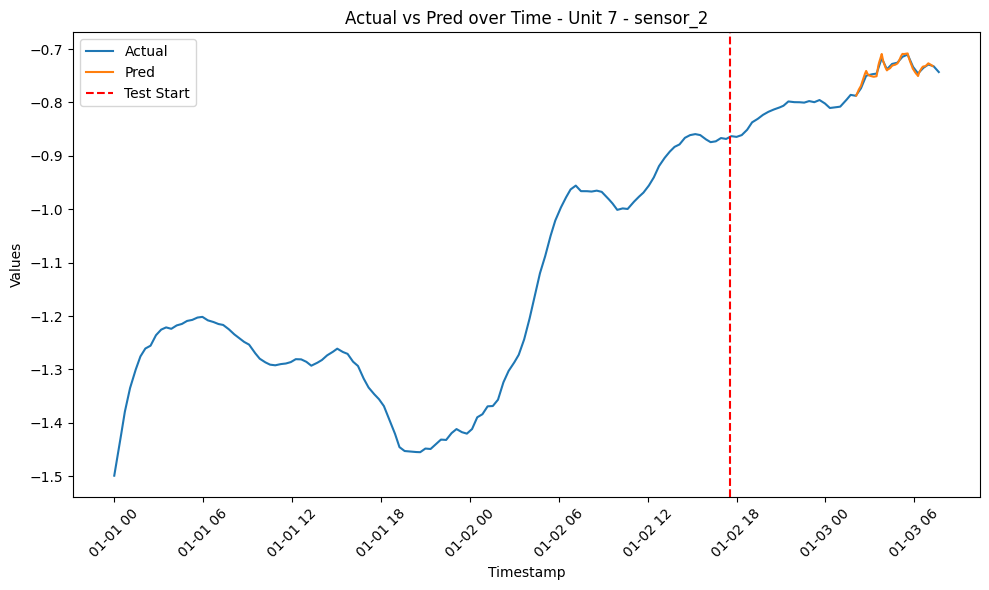

RMSE for Unit 7 - sensor_2: 0.013384393839556016


  0%|          | 0/96 [00:00<?, ?it/s]

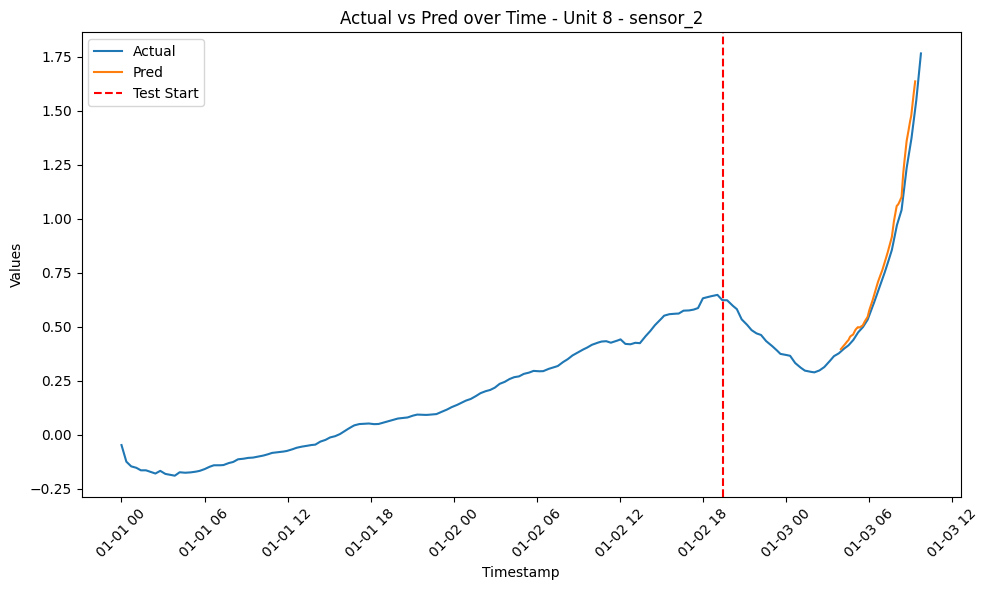

RMSE for Unit 8 - sensor_2: 0.051018407062451435


  0%|          | 0/78 [00:00<?, ?it/s]

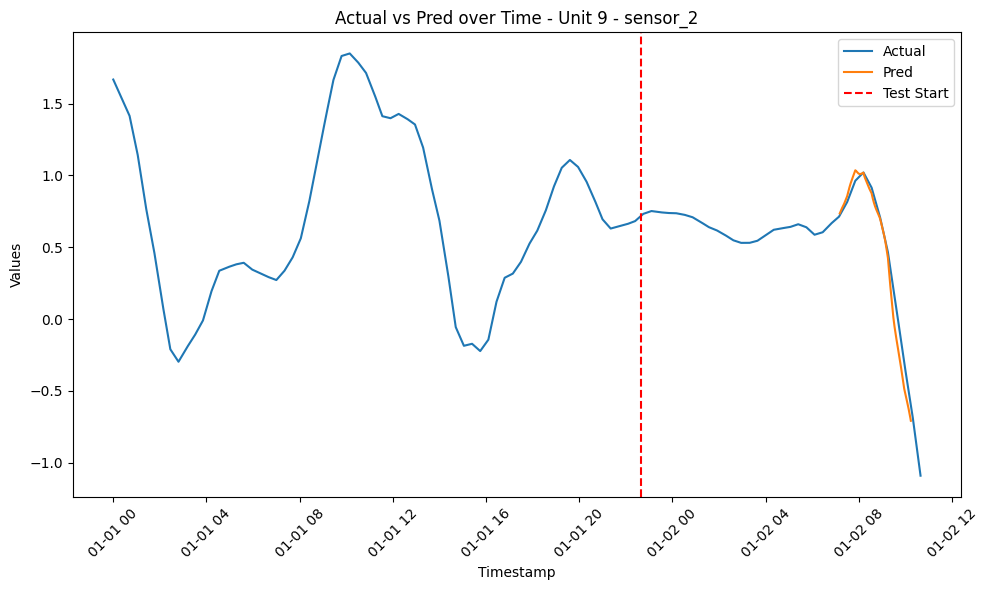

RMSE for Unit 9 - sensor_2: 0.22545324616287352


  0%|          | 0/103 [00:00<?, ?it/s]

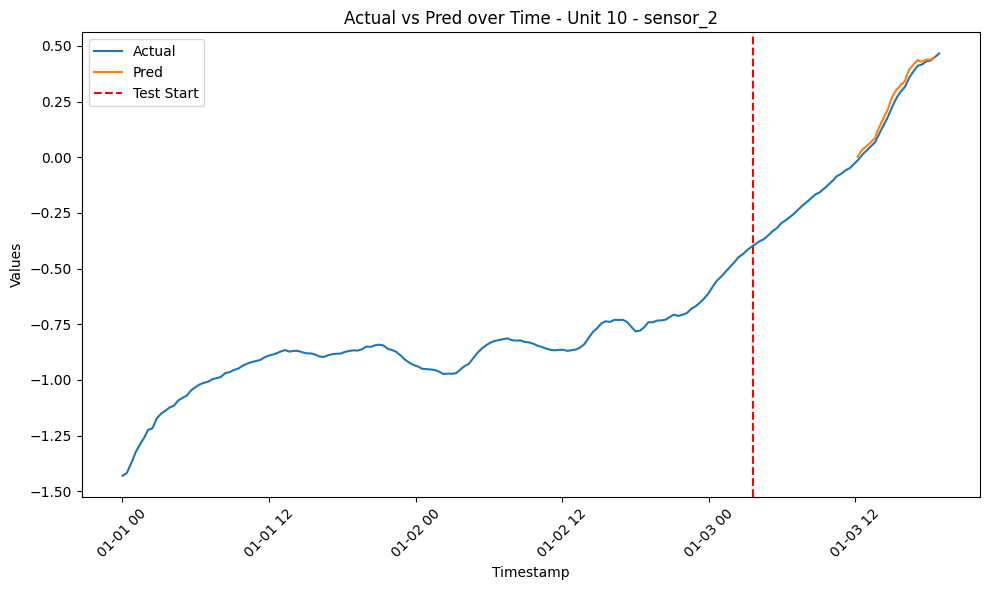

RMSE for Unit 10 - sensor_2: 0.010067249146326585


  0%|          | 0/78 [00:00<?, ?it/s]

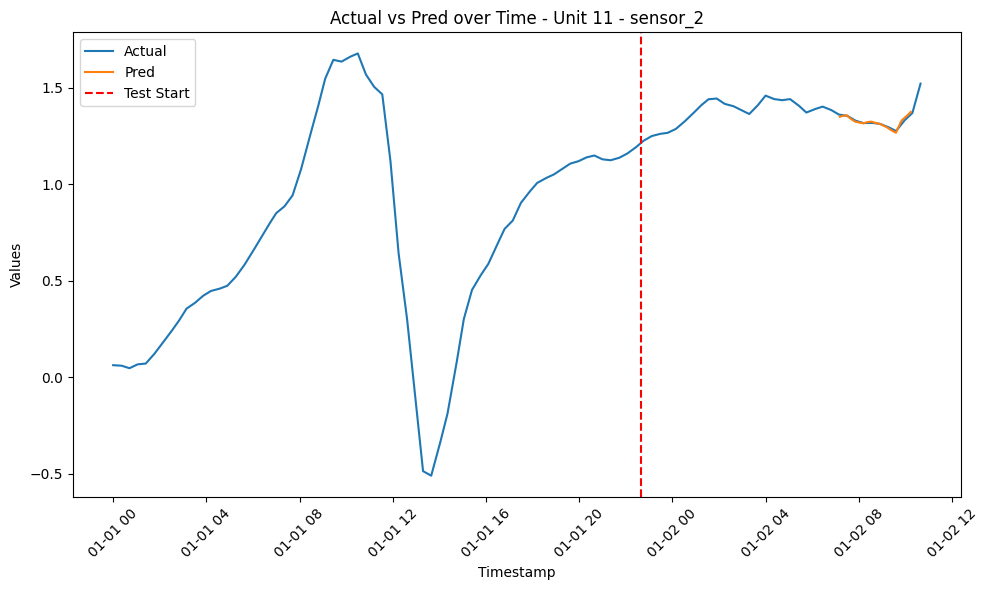

RMSE for Unit 11 - sensor_2: 0.038632645641023866


  0%|          | 0/109 [00:00<?, ?it/s]

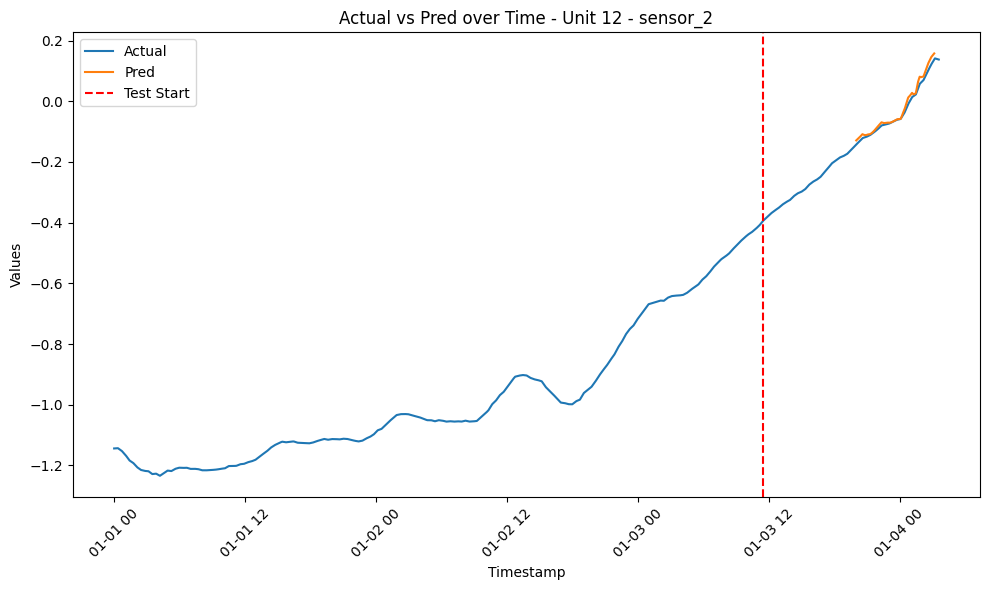

RMSE for Unit 12 - sensor_2: 0.010589238353129169


  0%|          | 0/103 [00:00<?, ?it/s]

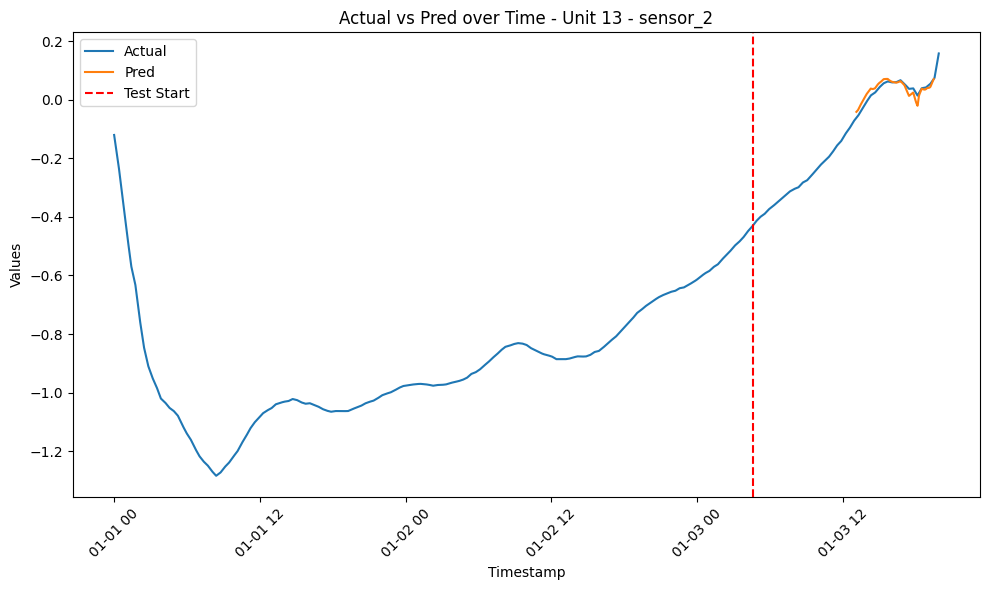

RMSE for Unit 13 - sensor_2: 0.020327270523210185


  0%|          | 0/78 [00:00<?, ?it/s]

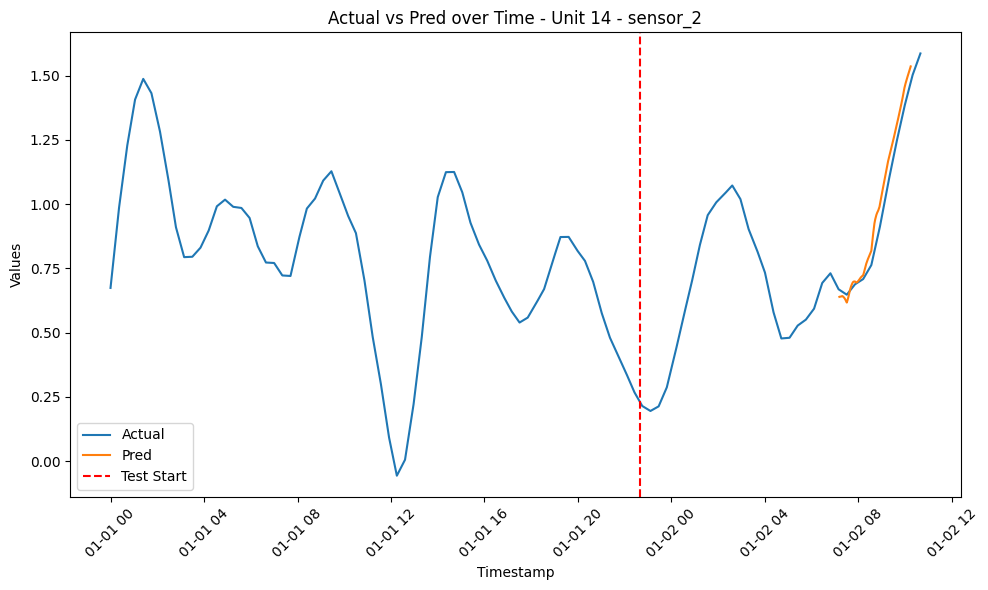

RMSE for Unit 14 - sensor_2: 0.07305632050892234


  0%|          | 0/78 [00:00<?, ?it/s]

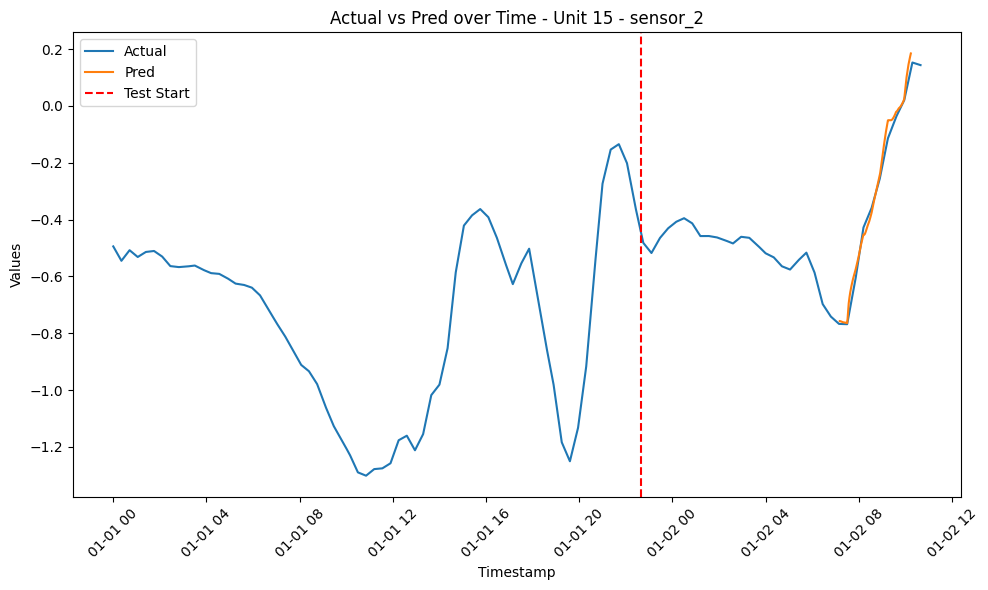

RMSE for Unit 15 - sensor_2: 0.11359995688103162


  0%|          | 0/82 [00:00<?, ?it/s]

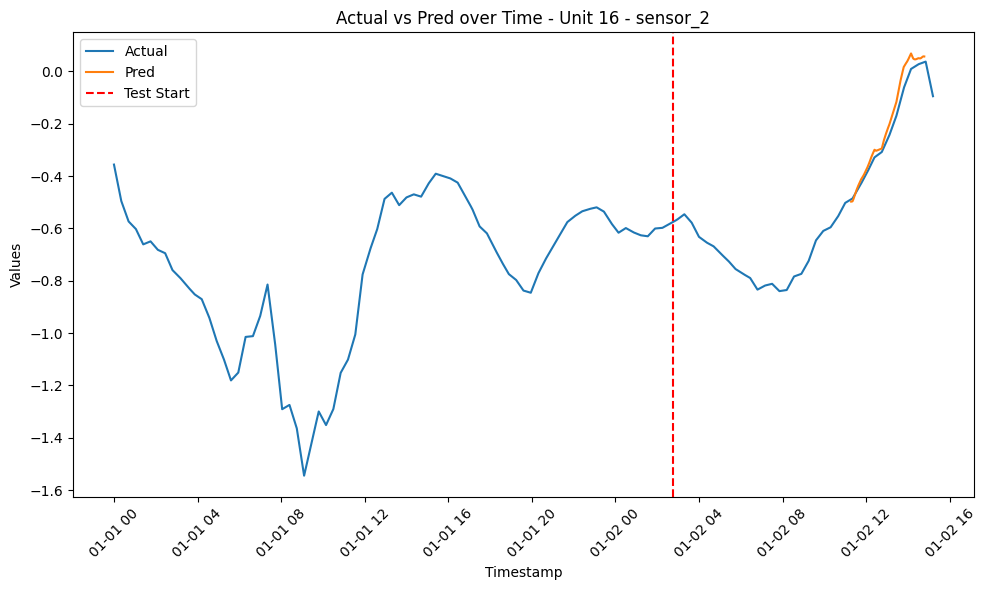

RMSE for Unit 16 - sensor_2: 0.04843878899535619


  0%|          | 0/96 [00:00<?, ?it/s]

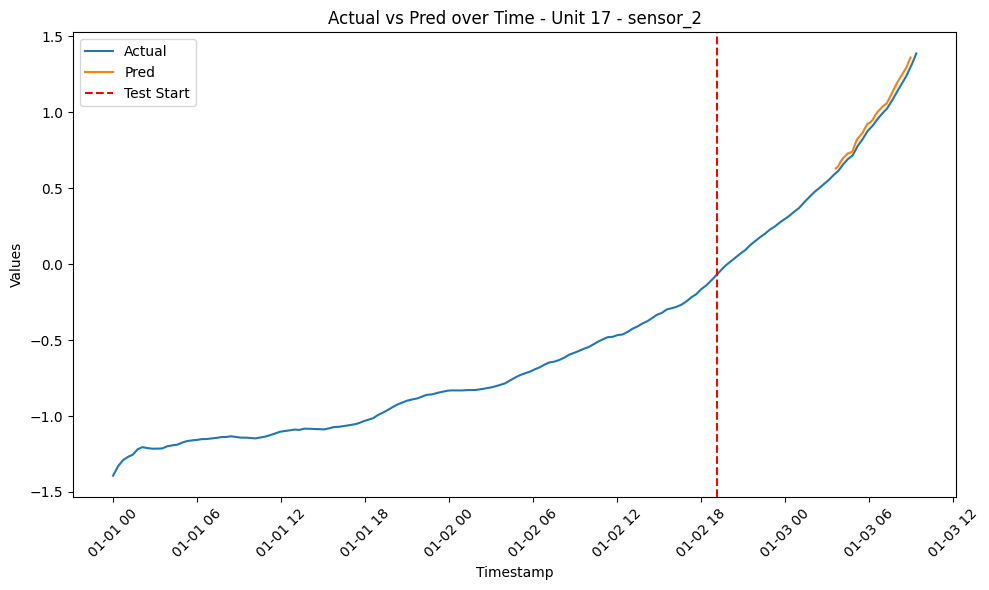

RMSE for Unit 17 - sensor_2: 0.013047345934281978


  0%|          | 0/87 [00:00<?, ?it/s]

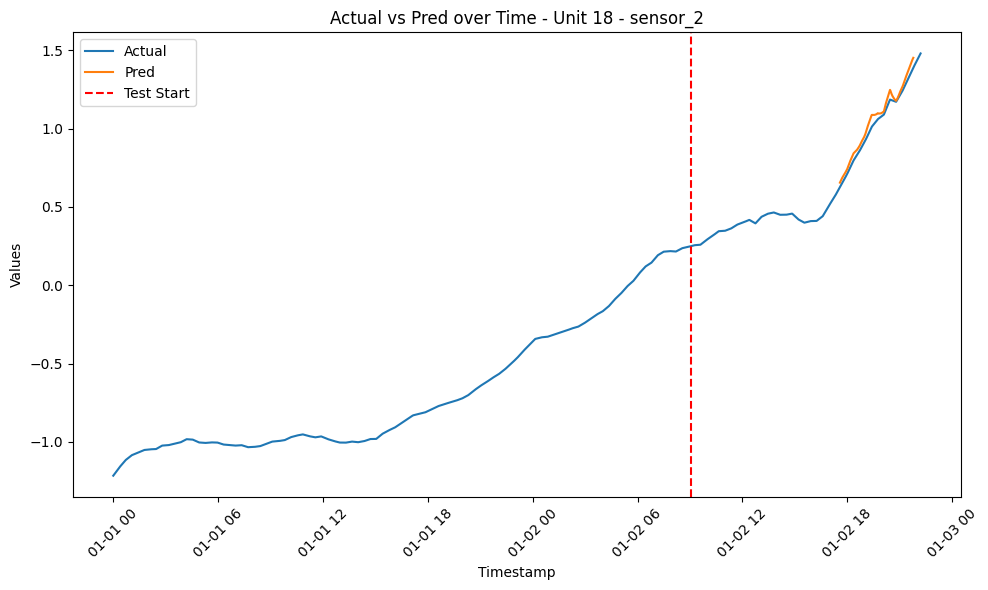

RMSE for Unit 18 - sensor_2: 0.04705079212965047


  0%|          | 0/88 [00:00<?, ?it/s]

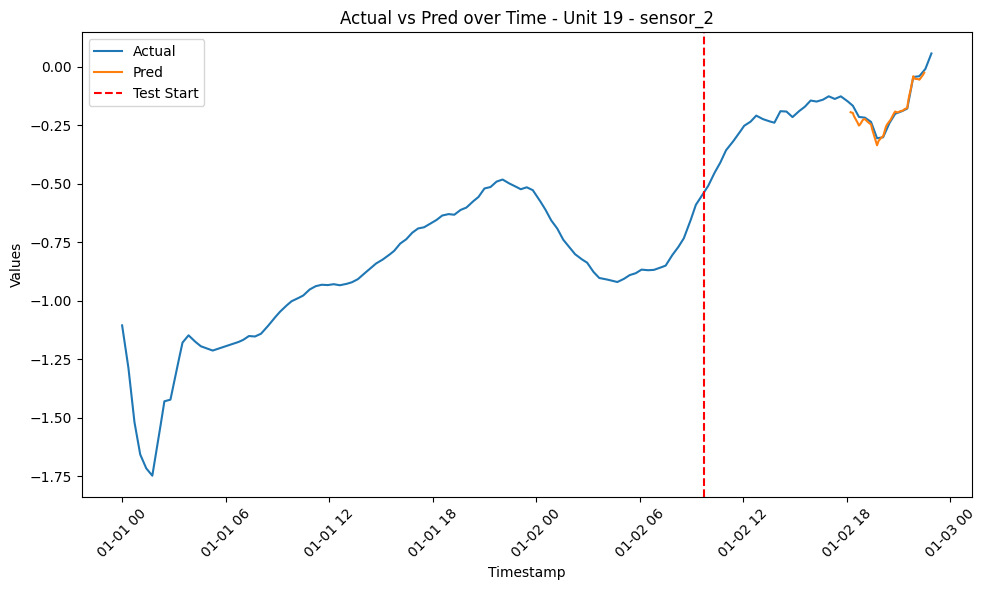

RMSE for Unit 19 - sensor_2: 0.04766938777291152


  0%|          | 0/100 [00:00<?, ?it/s]

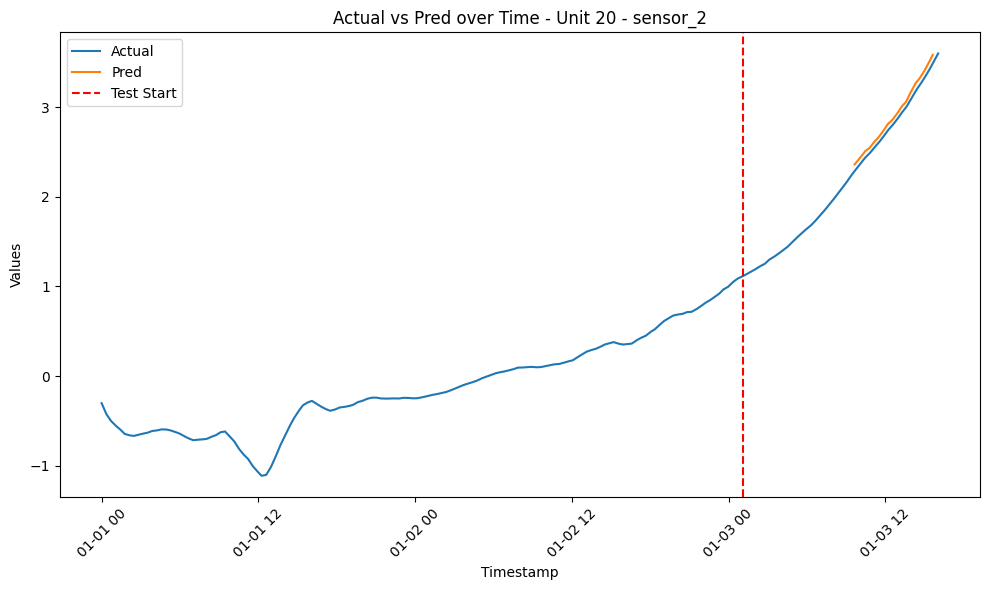

RMSE for Unit 20 - sensor_2: 0.013495300934768164


  0%|          | 0/91 [00:00<?, ?it/s]

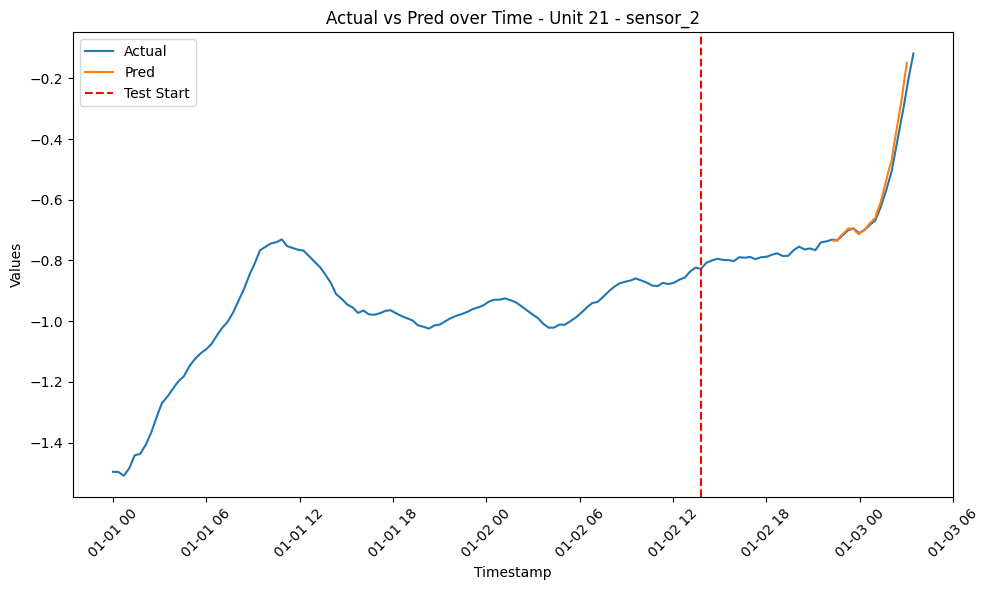

RMSE for Unit 21 - sensor_2: 0.036244459099105564


  0%|          | 0/78 [00:00<?, ?it/s]

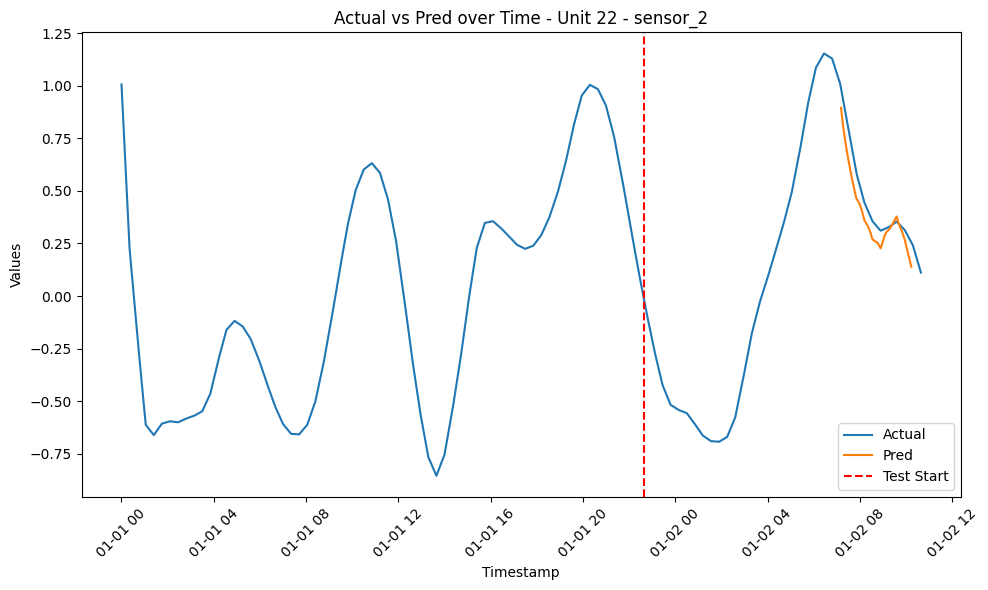

RMSE for Unit 22 - sensor_2: 0.05980107909077789


  0%|          | 0/86 [00:00<?, ?it/s]

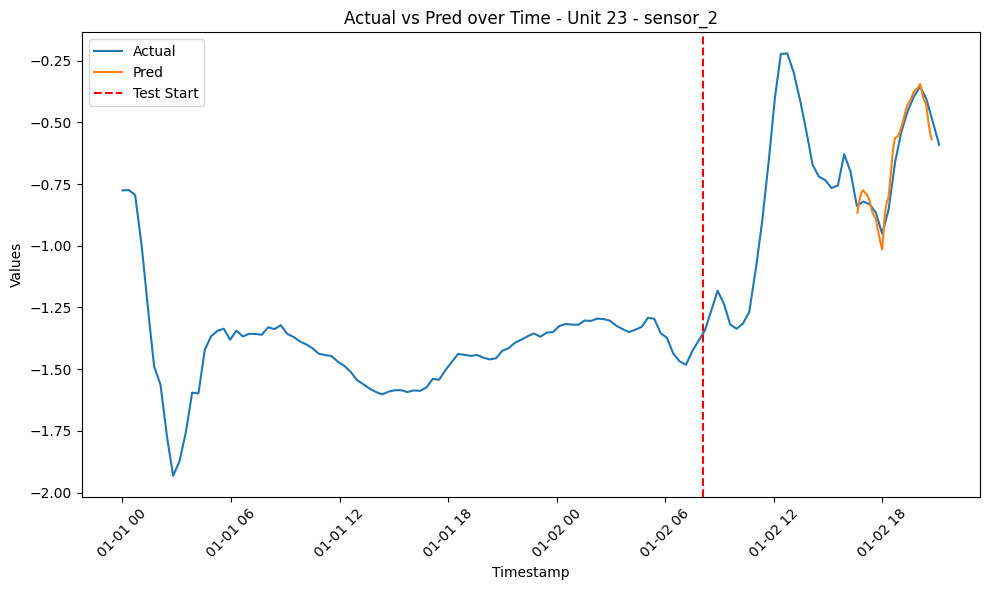

RMSE for Unit 23 - sensor_2: 0.07359352124721136


  0%|          | 0/101 [00:00<?, ?it/s]

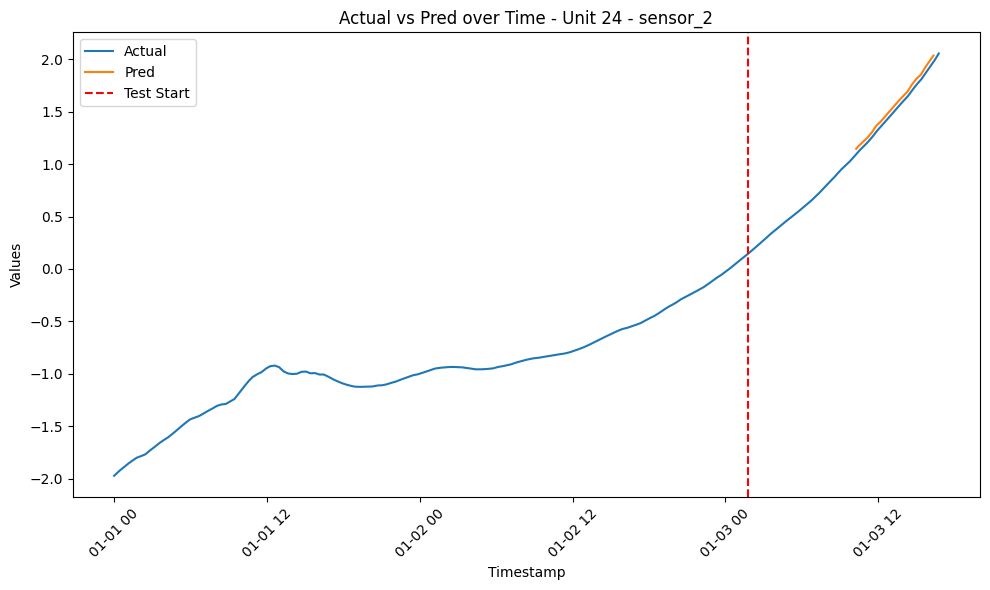

RMSE for Unit 24 - sensor_2: 0.008146164544793066


  0%|          | 0/78 [00:00<?, ?it/s]

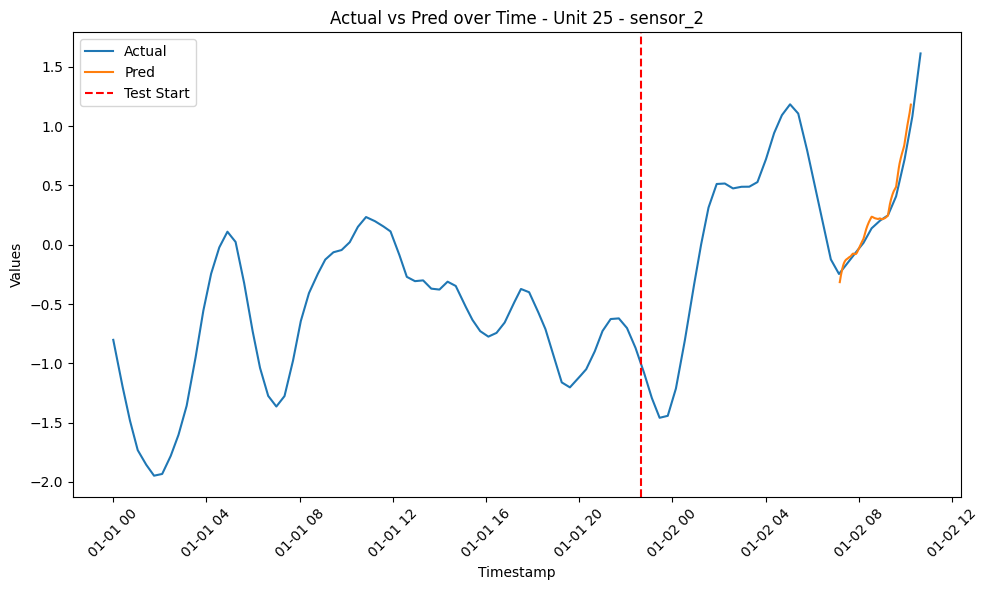

RMSE for Unit 25 - sensor_2: 0.17540823754417117


  0%|          | 0/78 [00:00<?, ?it/s]

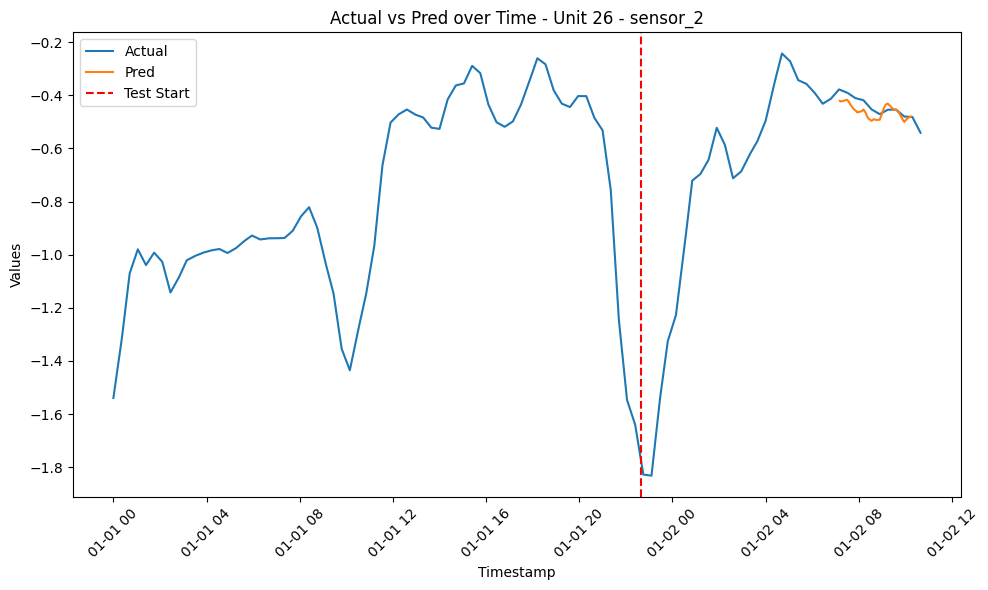

RMSE for Unit 26 - sensor_2: 0.023570226545219515


  0%|          | 0/89 [00:00<?, ?it/s]

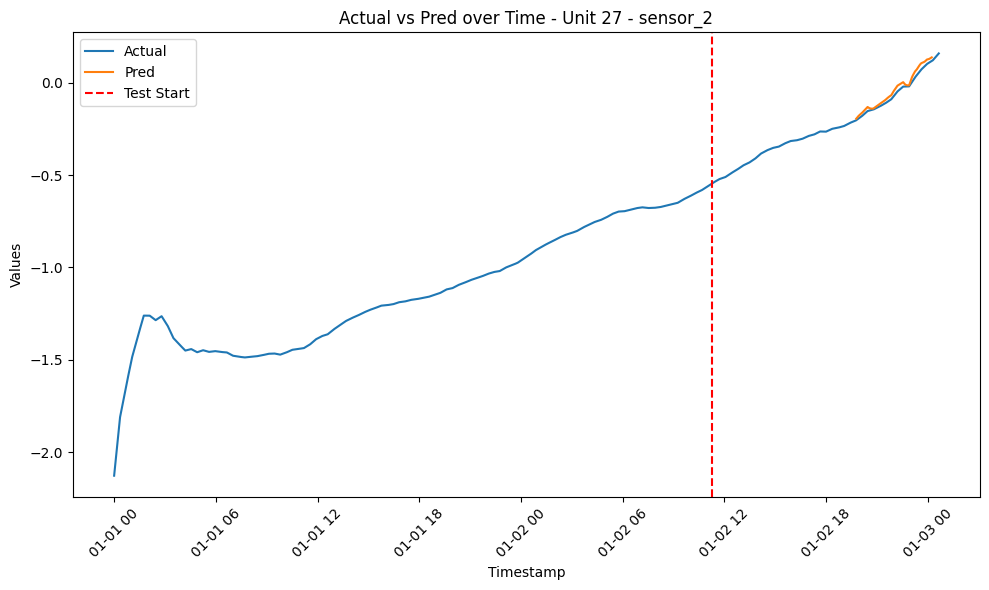

RMSE for Unit 27 - sensor_2: 0.015440872817980173


  0%|          | 0/94 [00:00<?, ?it/s]

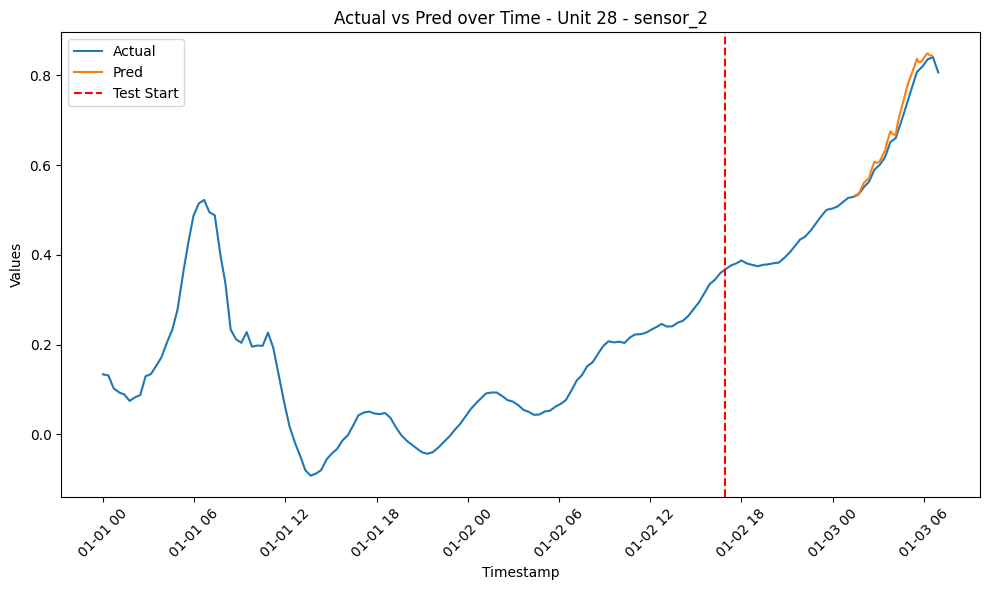

RMSE for Unit 28 - sensor_2: 0.01363003581887497


  0%|          | 0/97 [00:00<?, ?it/s]

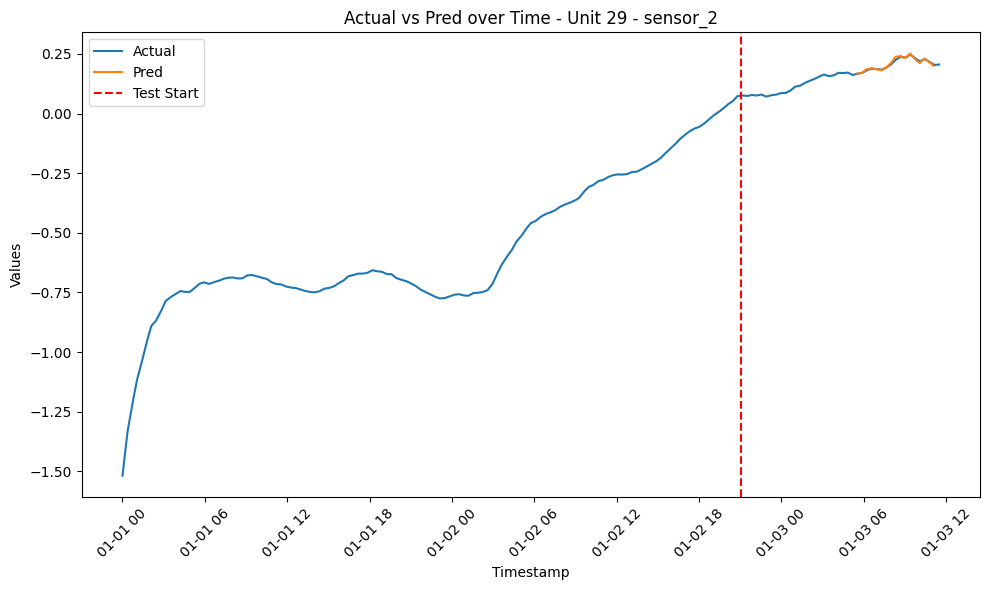

RMSE for Unit 29 - sensor_2: 0.01004086794908762


  0%|          | 0/90 [00:00<?, ?it/s]

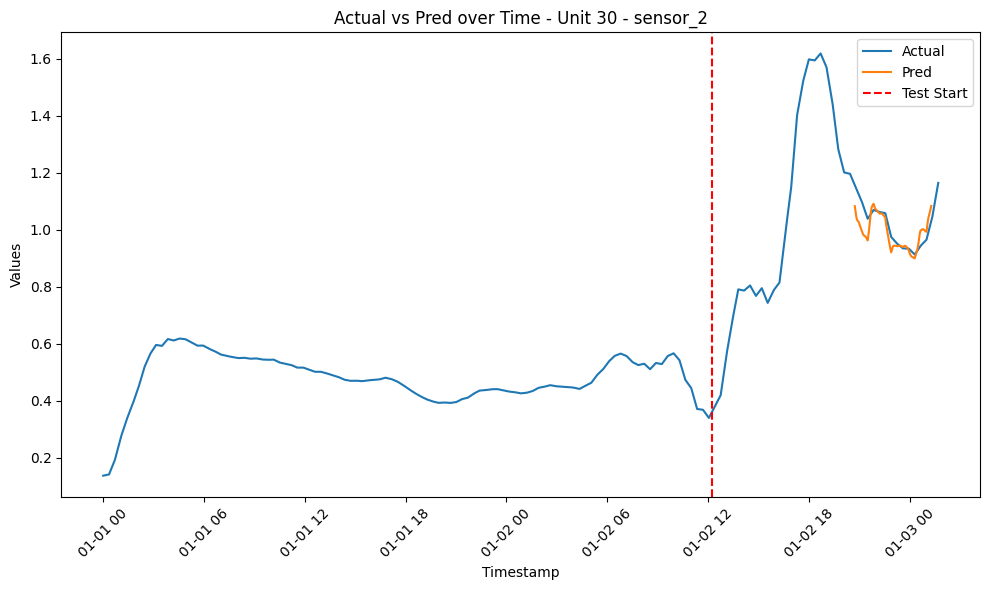

RMSE for Unit 30 - sensor_2: 0.04054932476958226


  0%|          | 0/104 [00:00<?, ?it/s]

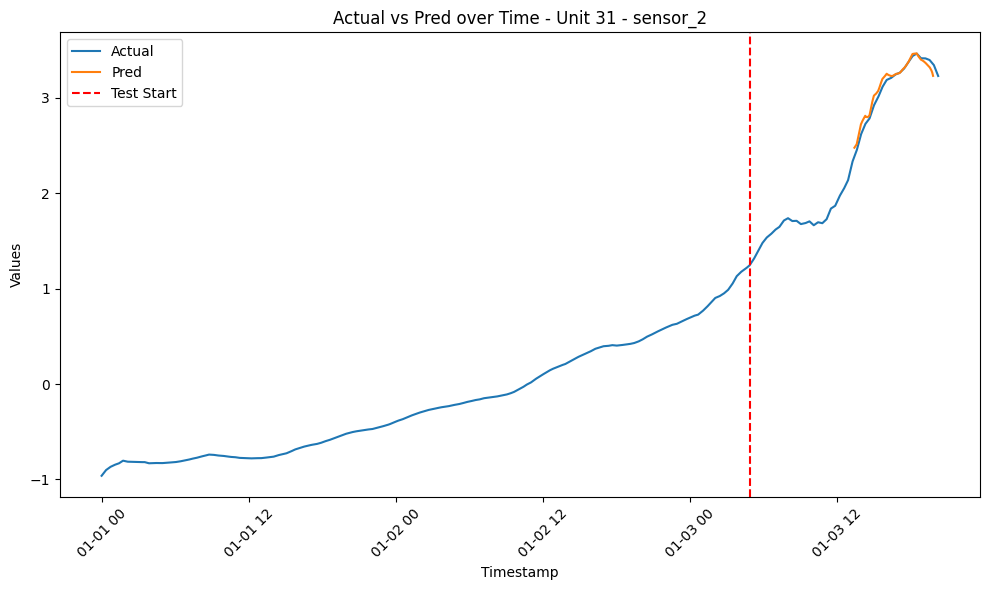

RMSE for Unit 31 - sensor_2: 0.04574574154700766


  0%|          | 0/90 [00:00<?, ?it/s]

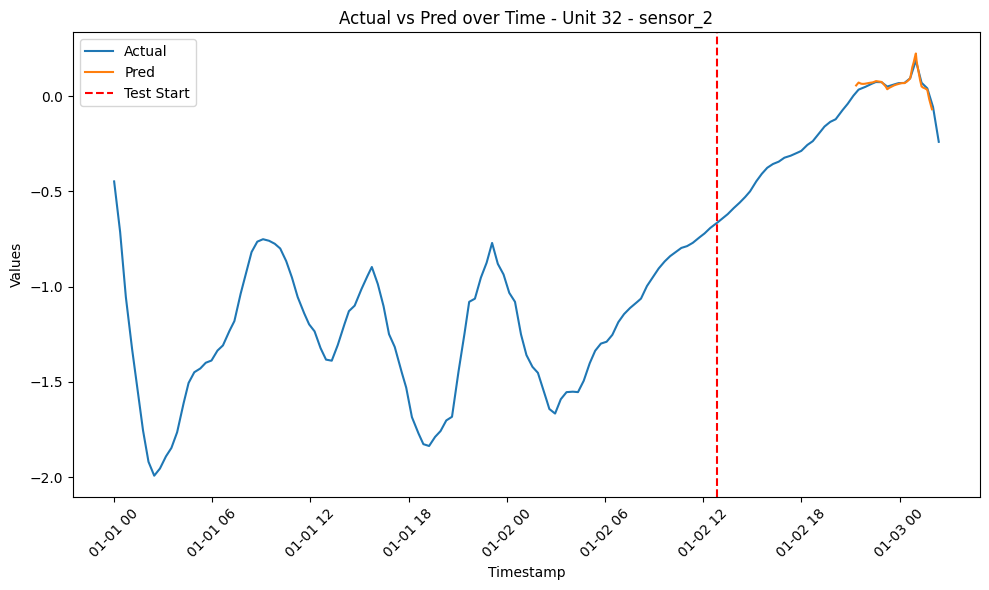

RMSE for Unit 32 - sensor_2: 0.05624779069834226


  0%|          | 0/78 [00:00<?, ?it/s]

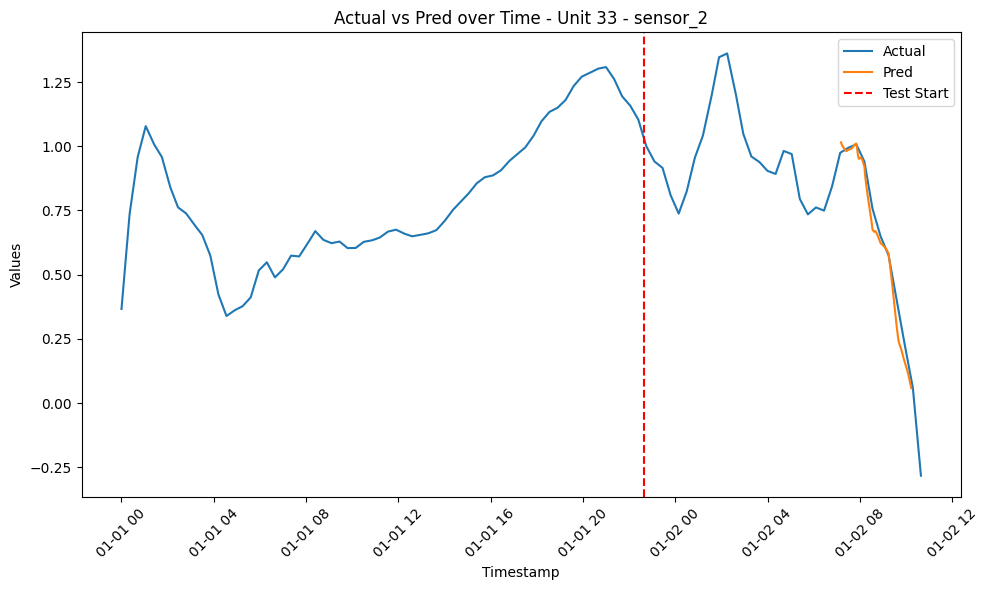

RMSE for Unit 33 - sensor_2: 0.12851109756289683


  0%|          | 0/105 [00:00<?, ?it/s]

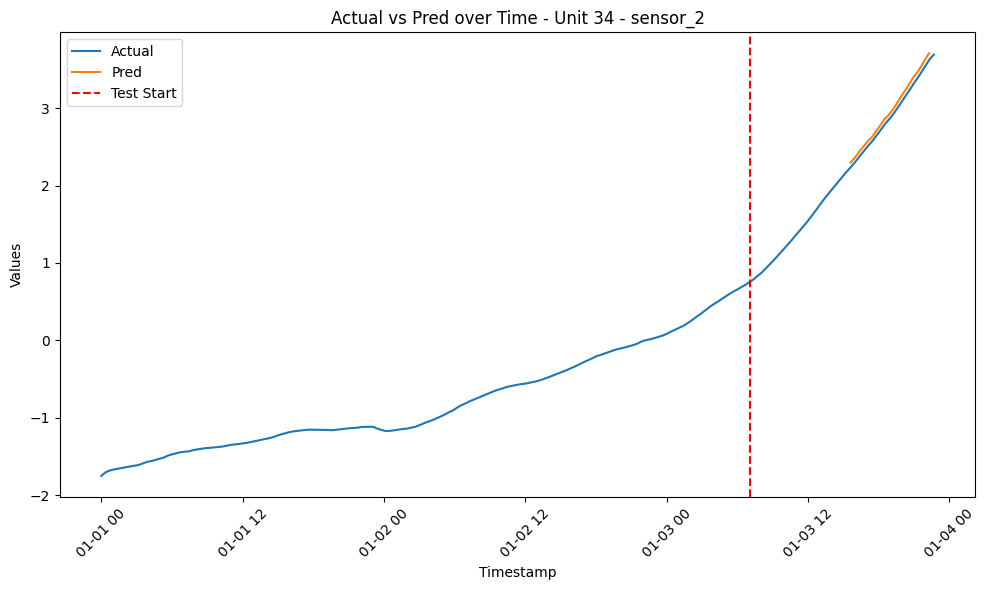

RMSE for Unit 34 - sensor_2: 0.013007745307410171


  0%|          | 0/104 [00:00<?, ?it/s]

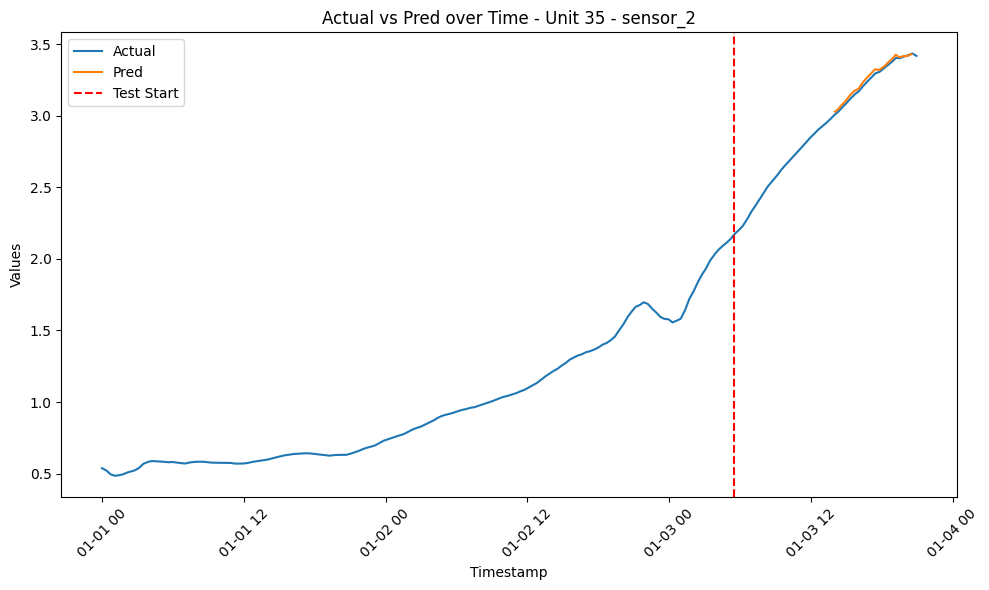

RMSE for Unit 35 - sensor_2: 0.01117274477472189


  0%|          | 0/85 [00:00<?, ?it/s]

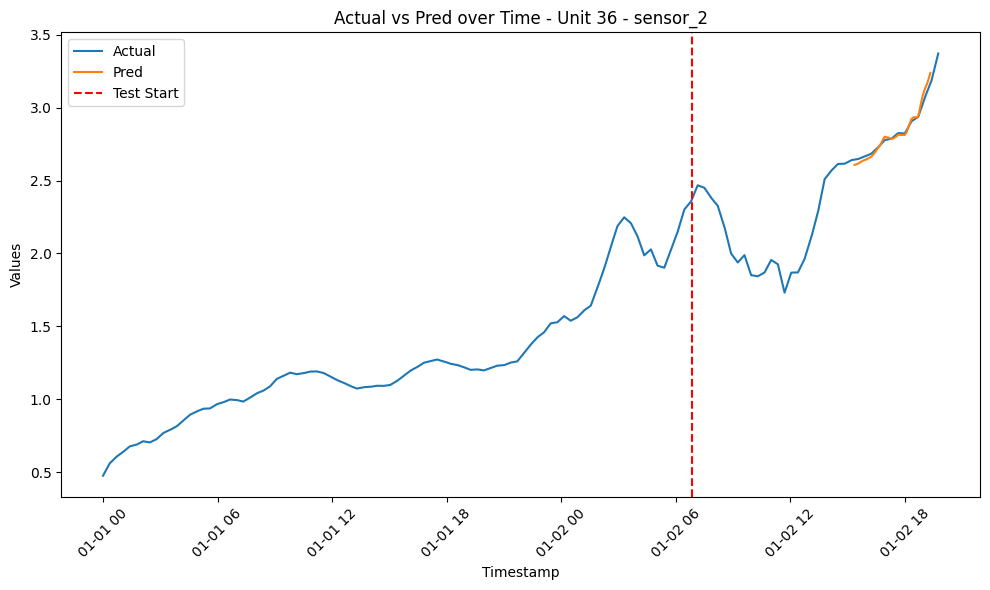

RMSE for Unit 36 - sensor_2: 0.06913996112974509


  0%|          | 0/84 [00:00<?, ?it/s]

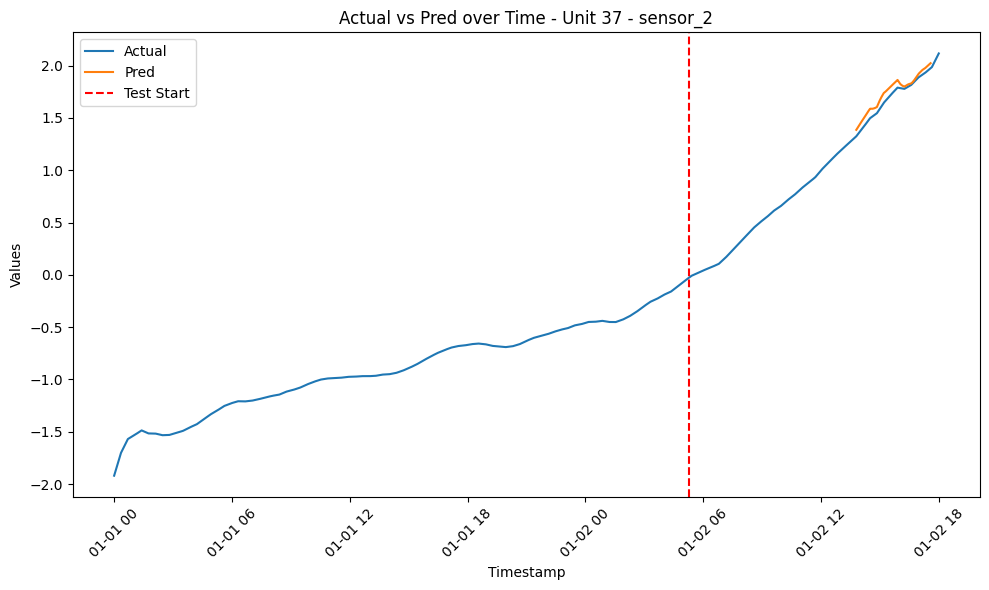

RMSE for Unit 37 - sensor_2: 0.036156771844471414


  0%|          | 0/85 [00:00<?, ?it/s]

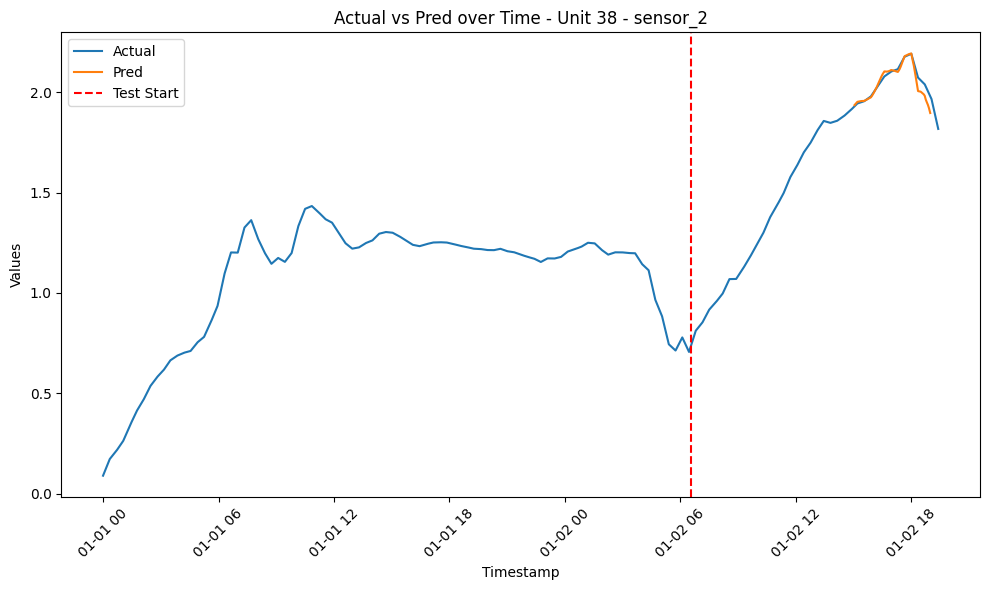

RMSE for Unit 38 - sensor_2: 0.04844068275210943


  0%|          | 0/78 [00:00<?, ?it/s]

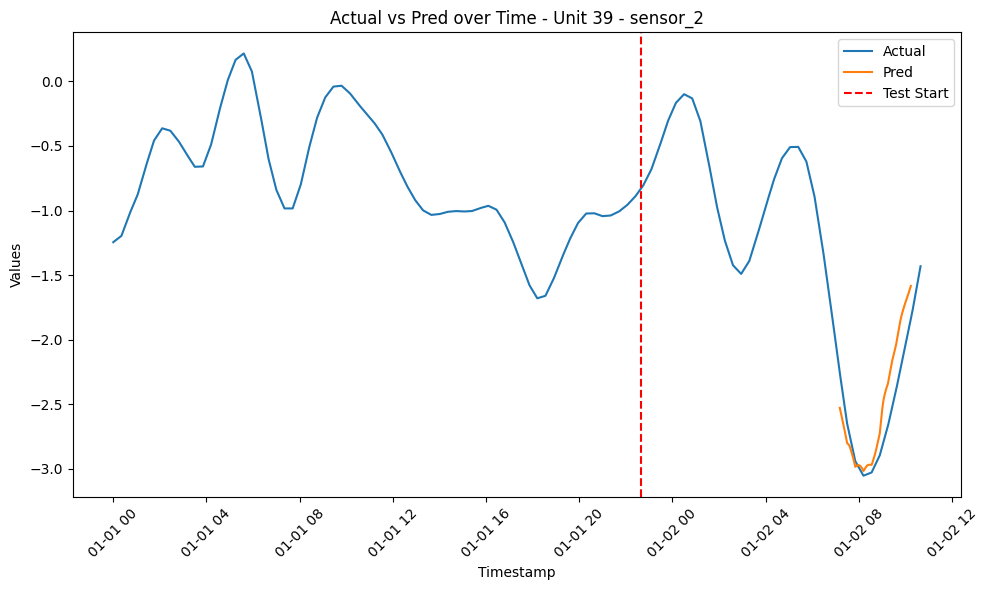

RMSE for Unit 39 - sensor_2: 0.0946215996608567


  0%|          | 0/87 [00:00<?, ?it/s]

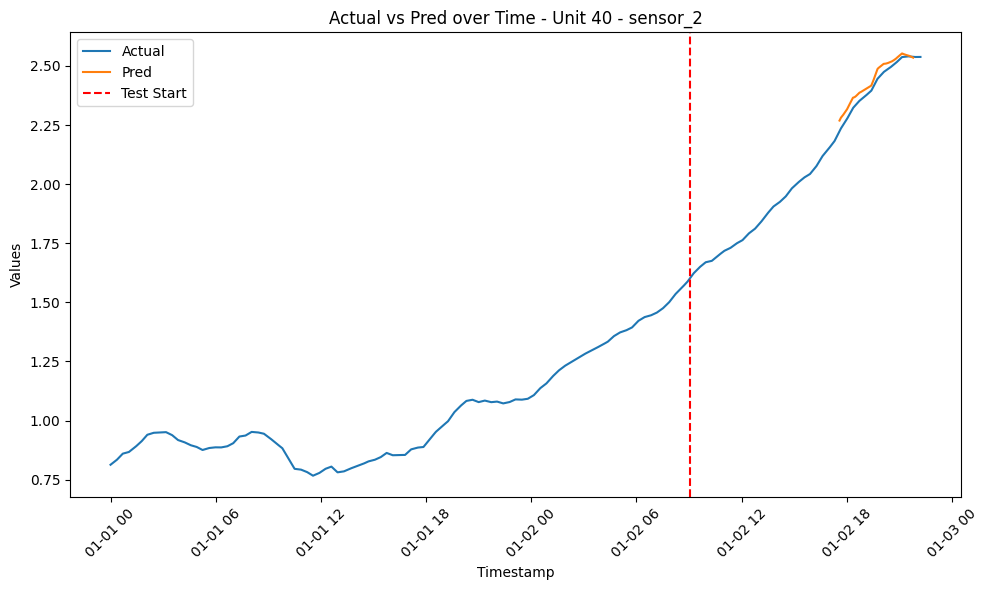

RMSE for Unit 40 - sensor_2: 0.010751368056546556


  0%|          | 0/84 [00:00<?, ?it/s]

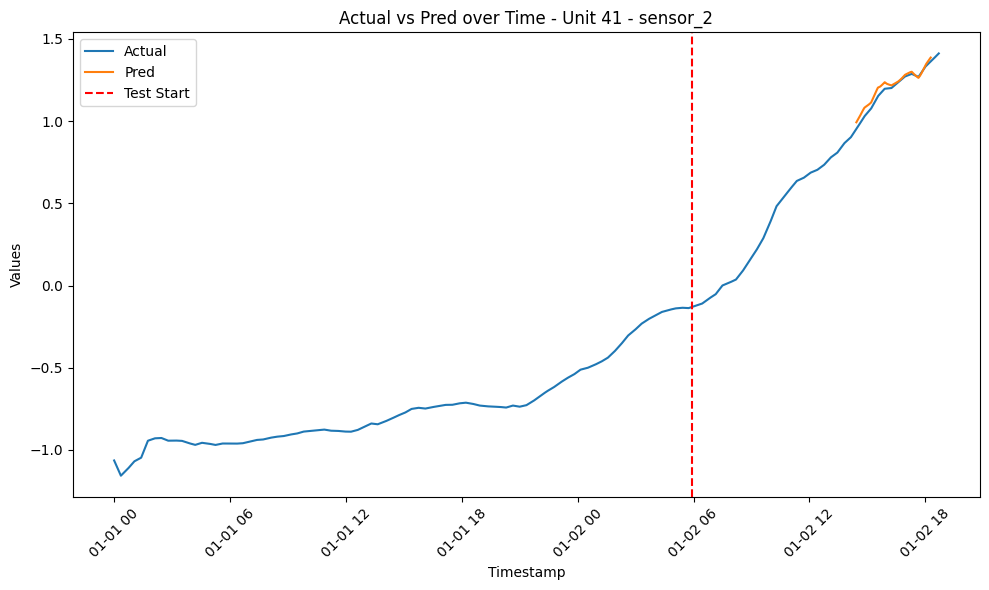

RMSE for Unit 41 - sensor_2: 0.030500977056837433


  0%|          | 0/93 [00:00<?, ?it/s]

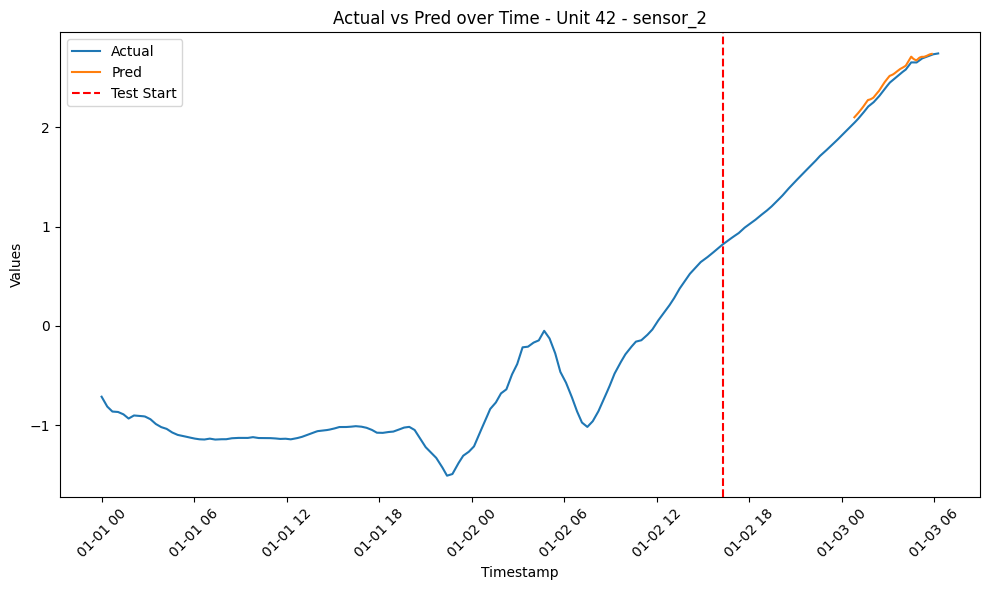

RMSE for Unit 42 - sensor_2: 0.016768416612111783


  0%|          | 0/97 [00:00<?, ?it/s]

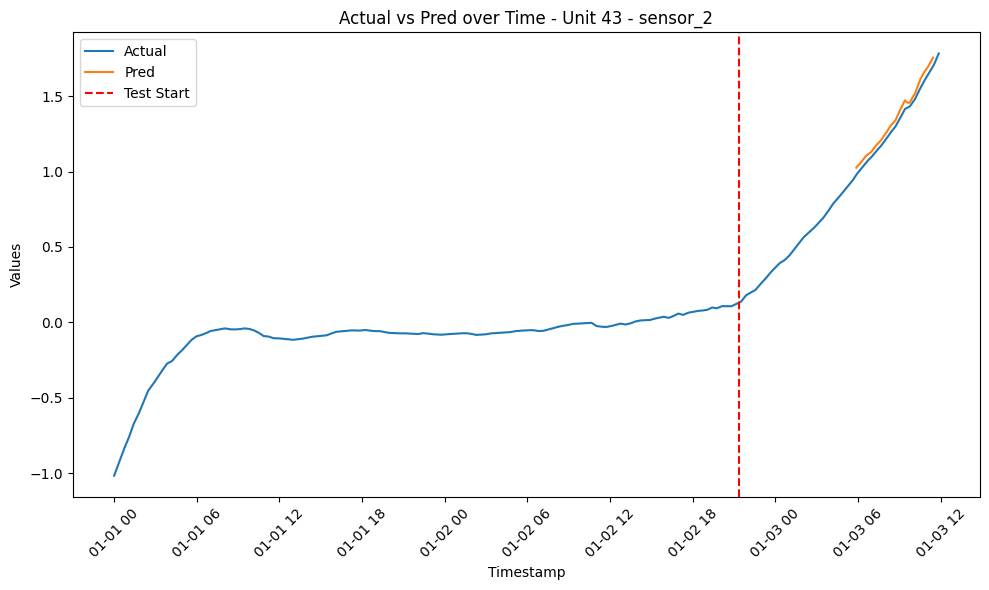

RMSE for Unit 43 - sensor_2: 0.015093688868976229


  0%|          | 0/78 [00:00<?, ?it/s]

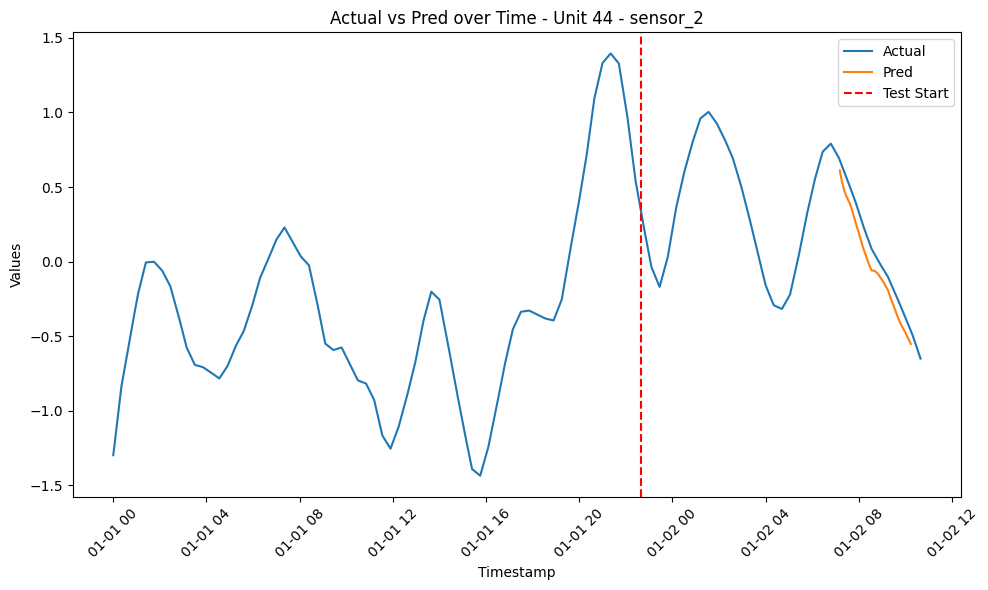

RMSE for Unit 44 - sensor_2: 0.0455502335332569


  0%|          | 0/92 [00:00<?, ?it/s]

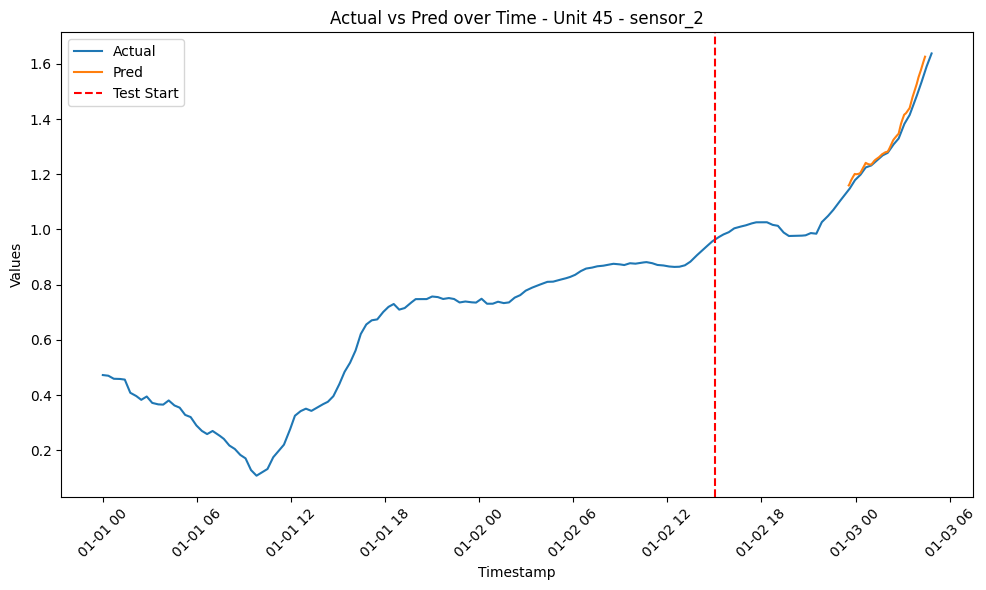

RMSE for Unit 45 - sensor_2: 0.01854782374738814


  0%|          | 0/91 [00:00<?, ?it/s]

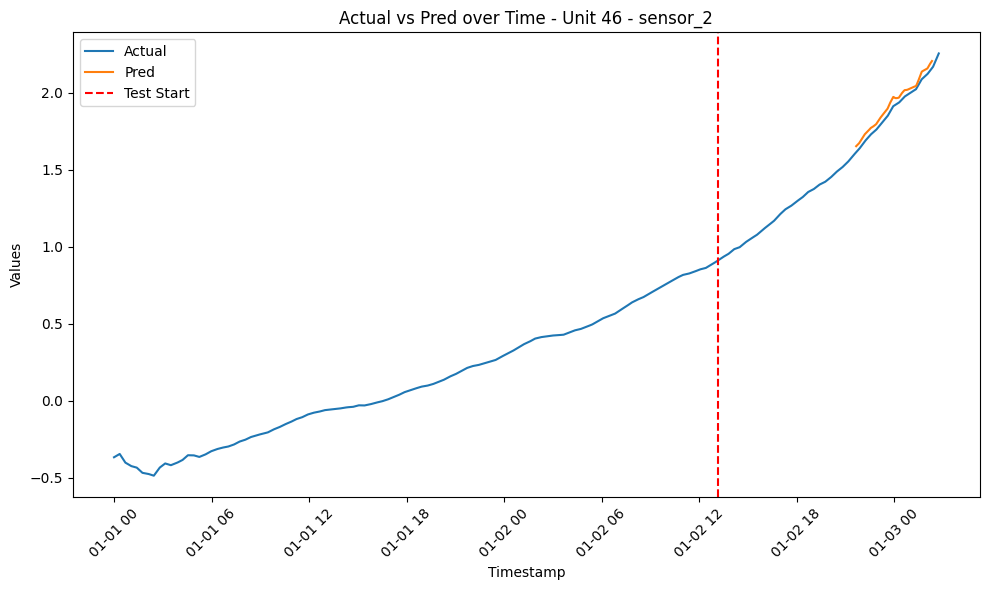

RMSE for Unit 46 - sensor_2: 0.01737939311034432


  0%|          | 0/78 [00:00<?, ?it/s]

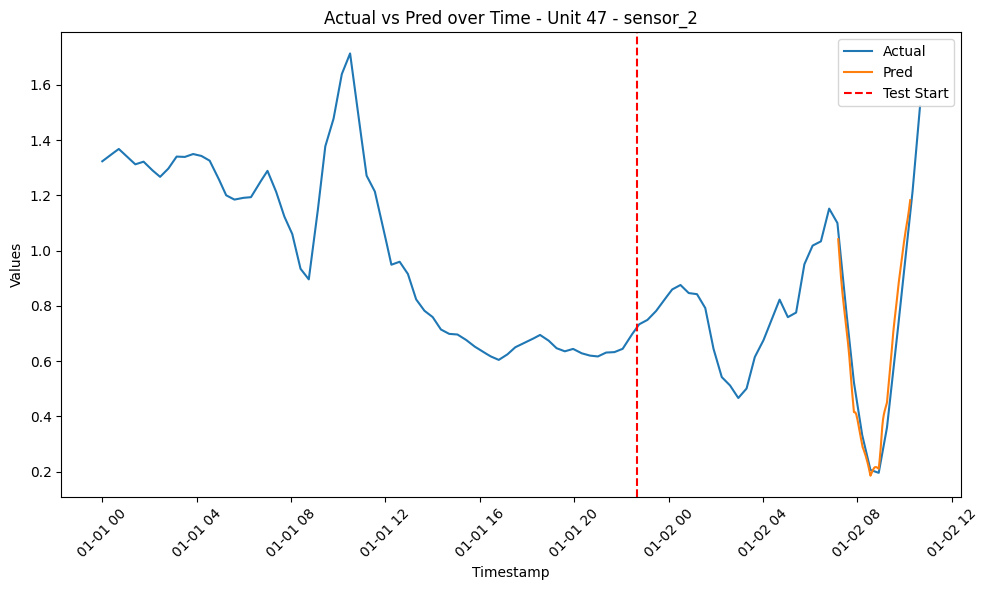

RMSE for Unit 47 - sensor_2: 0.1834758718362781


  0%|          | 0/78 [00:00<?, ?it/s]

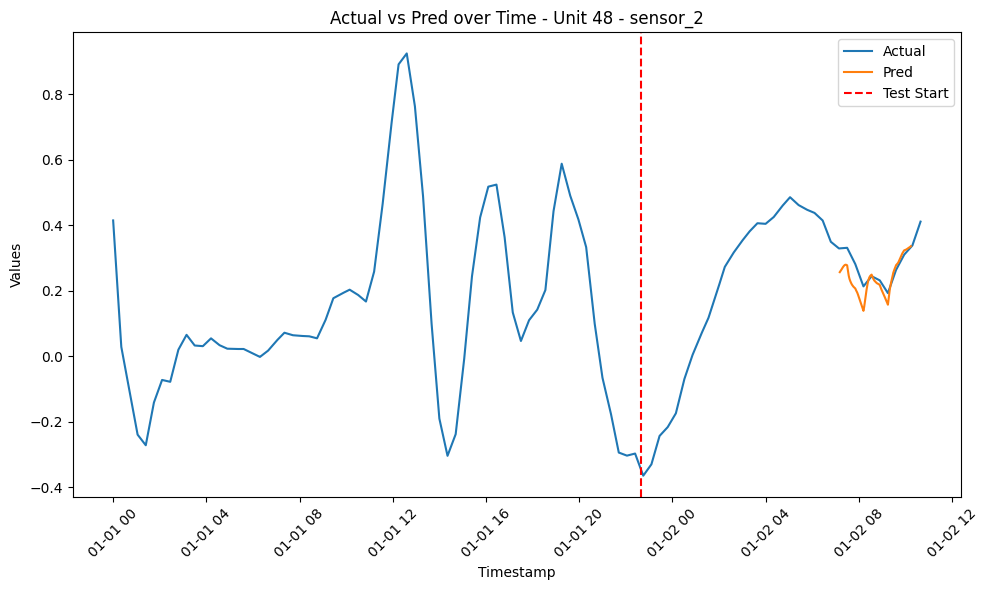

RMSE for Unit 48 - sensor_2: 0.04697501968200723


  0%|          | 0/132 [00:00<?, ?it/s]

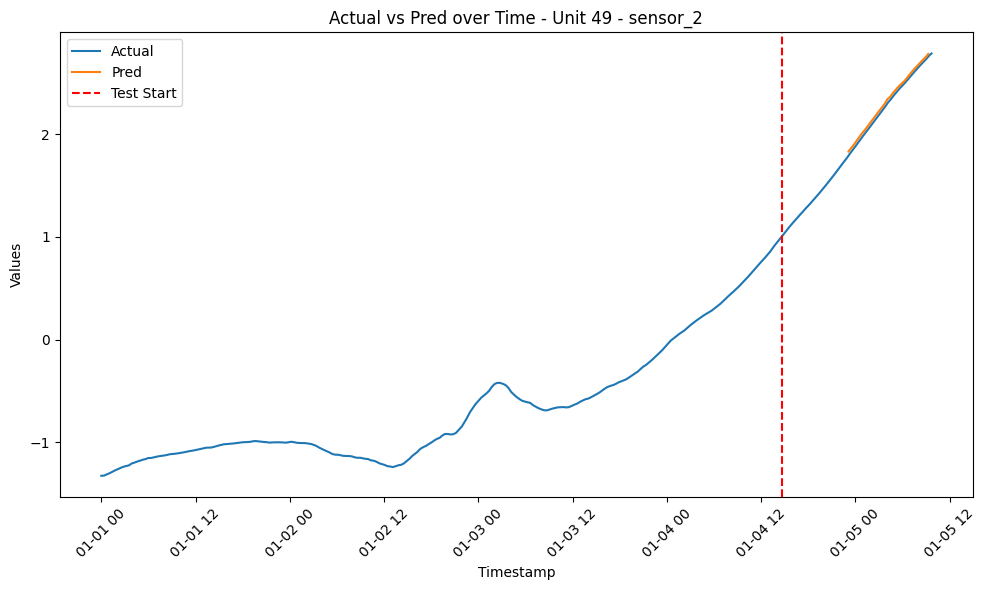

RMSE for Unit 49 - sensor_2: 0.006203219543689567


  0%|          | 0/78 [00:00<?, ?it/s]

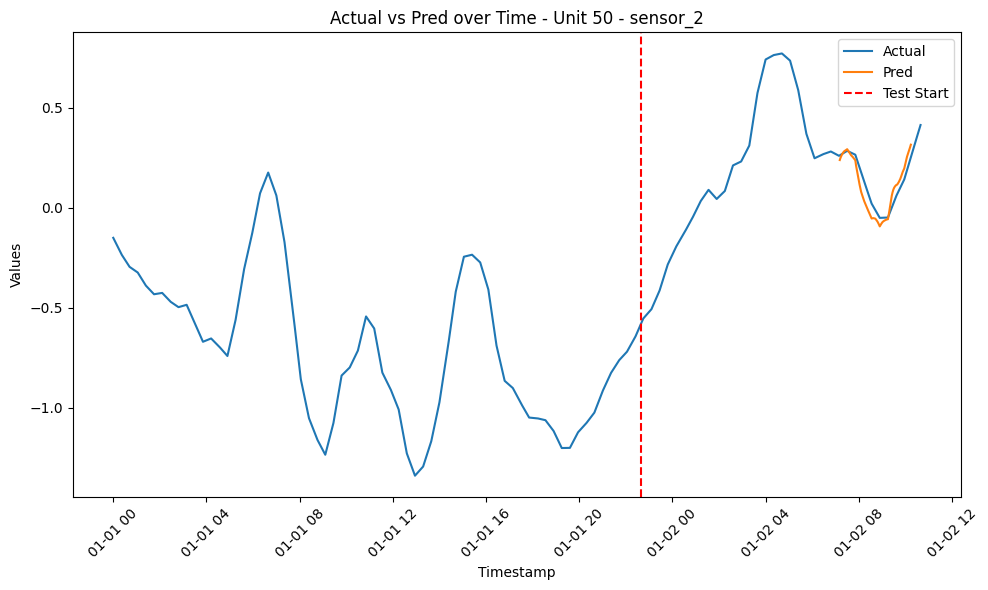

RMSE for Unit 50 - sensor_2: 0.06708600929009044


  0%|          | 0/90 [00:00<?, ?it/s]

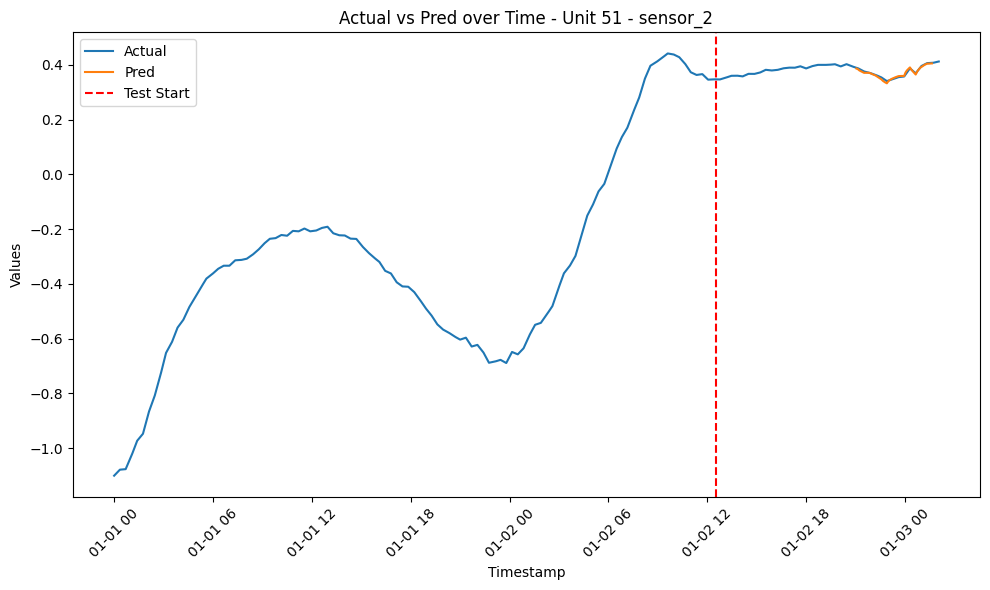

RMSE for Unit 51 - sensor_2: 0.011623811266613656


  0%|          | 0/102 [00:00<?, ?it/s]

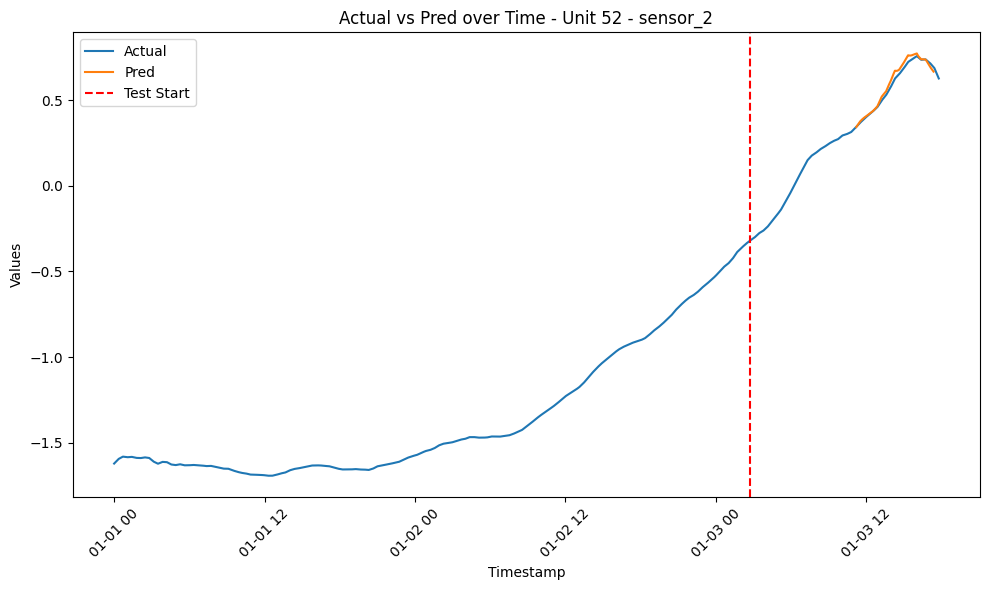

RMSE for Unit 52 - sensor_2: 0.021078249401061306


  0%|          | 0/95 [00:00<?, ?it/s]

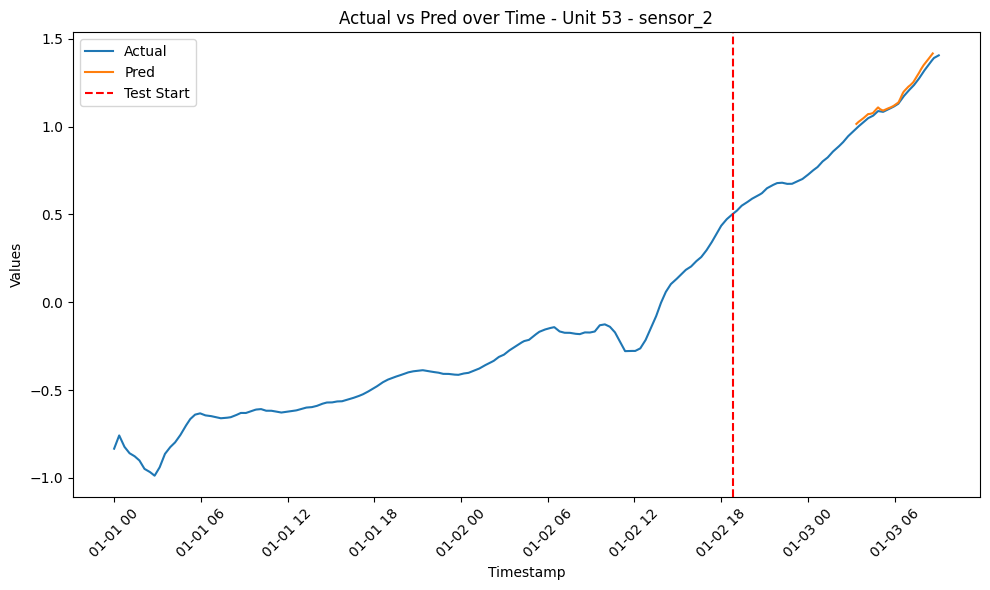

RMSE for Unit 53 - sensor_2: 0.01486898794890146


  0%|          | 0/84 [00:00<?, ?it/s]

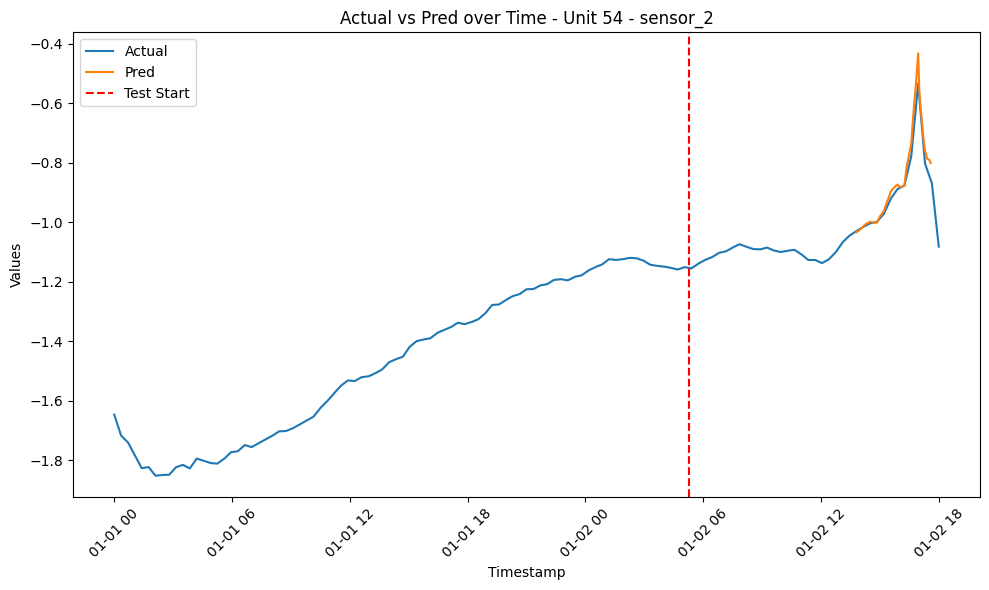

RMSE for Unit 54 - sensor_2: 0.12255611564550872


  0%|          | 0/82 [00:00<?, ?it/s]

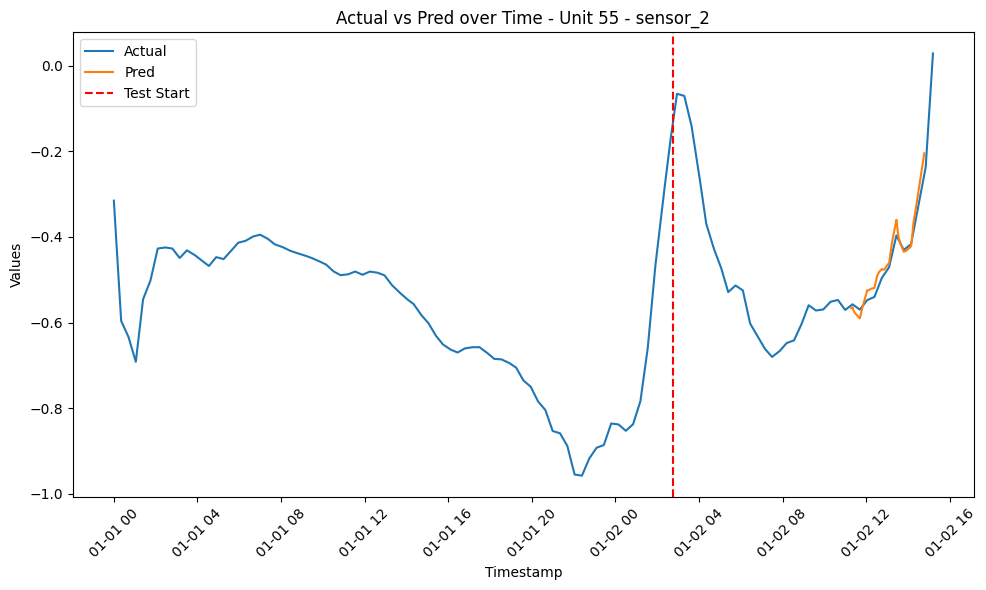

RMSE for Unit 55 - sensor_2: 0.06438324157169191


  0%|          | 0/88 [00:00<?, ?it/s]

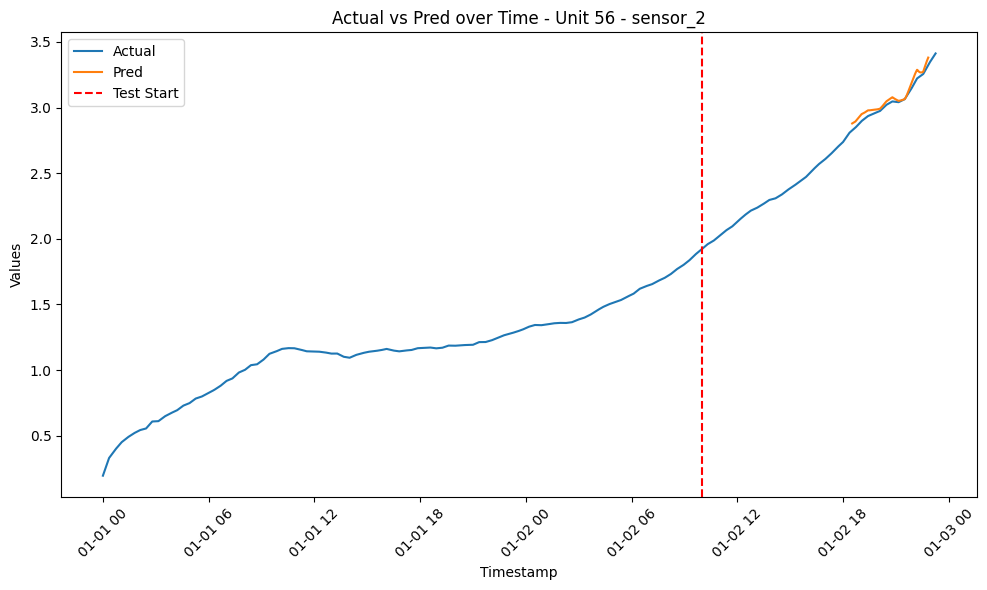

RMSE for Unit 56 - sensor_2: 0.036225771946205874


  0%|          | 0/94 [00:00<?, ?it/s]

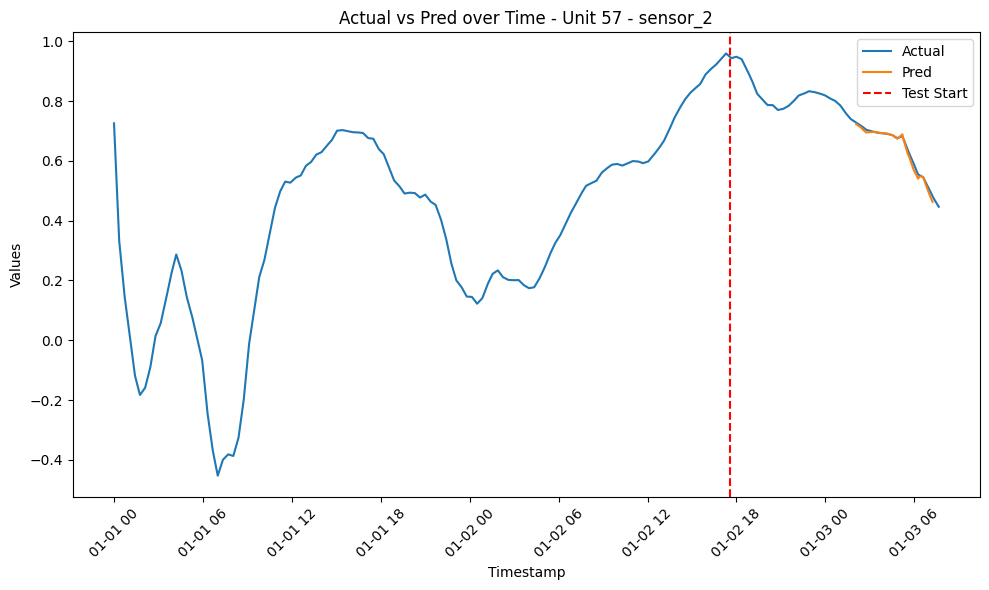

RMSE for Unit 57 - sensor_2: 0.020978798503155507


  0%|          | 0/98 [00:00<?, ?it/s]

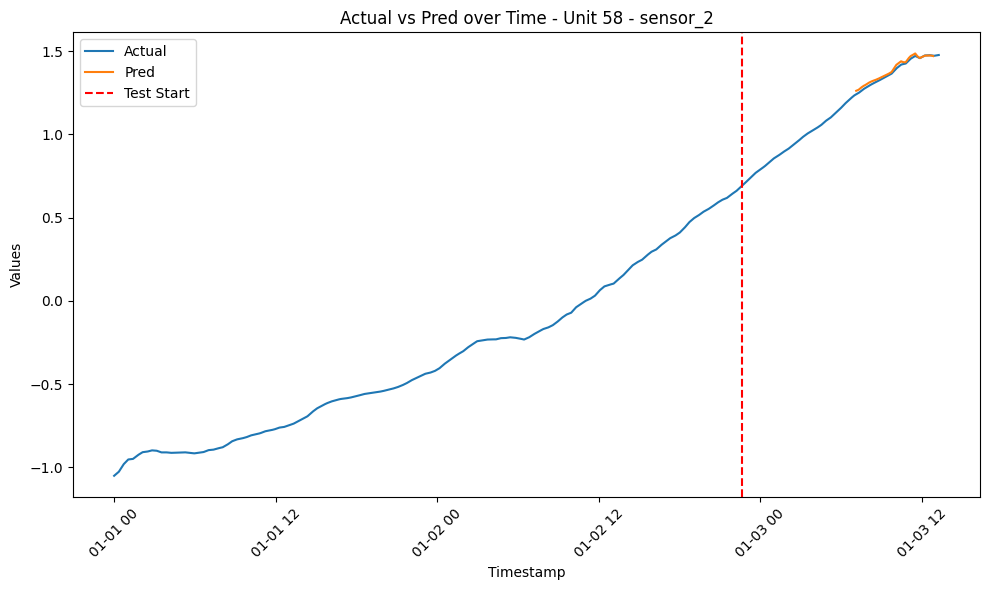

RMSE for Unit 58 - sensor_2: 0.0099610929632499


  0%|          | 0/78 [00:00<?, ?it/s]

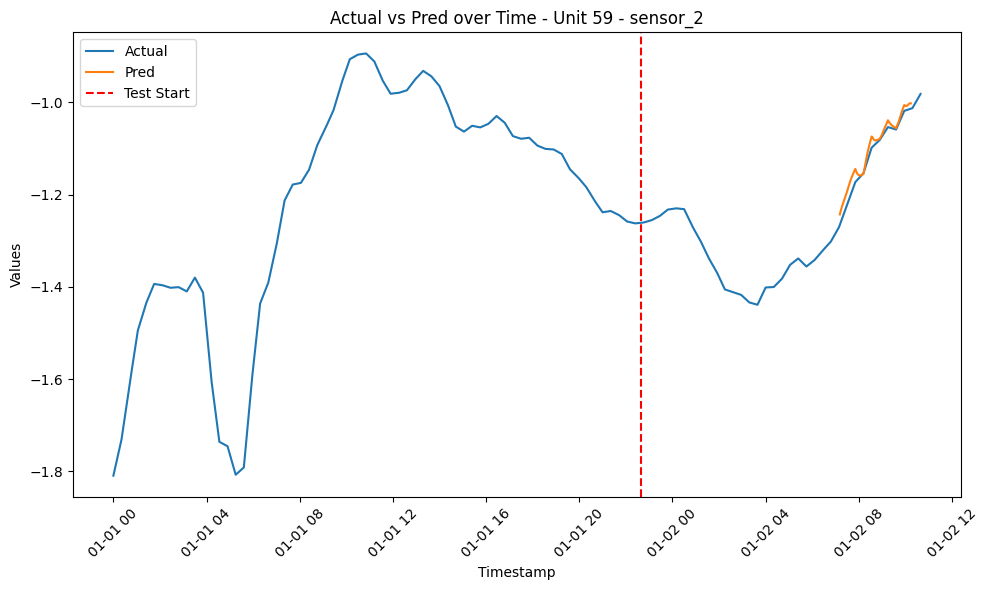

RMSE for Unit 59 - sensor_2: 0.024075197687075788


  0%|          | 0/91 [00:00<?, ?it/s]

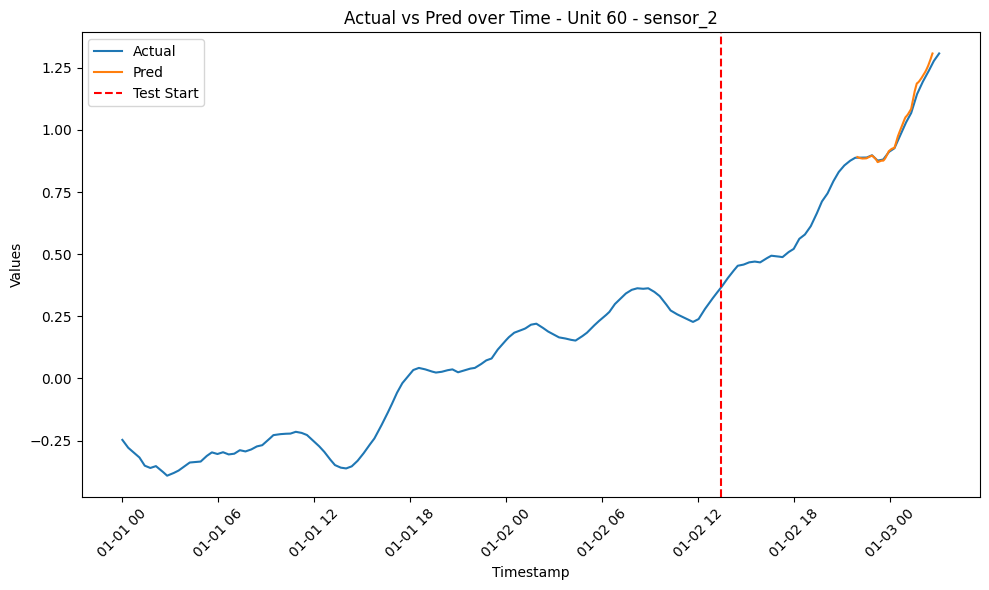

RMSE for Unit 60 - sensor_2: 0.02866999282184981


  0%|          | 0/94 [00:00<?, ?it/s]

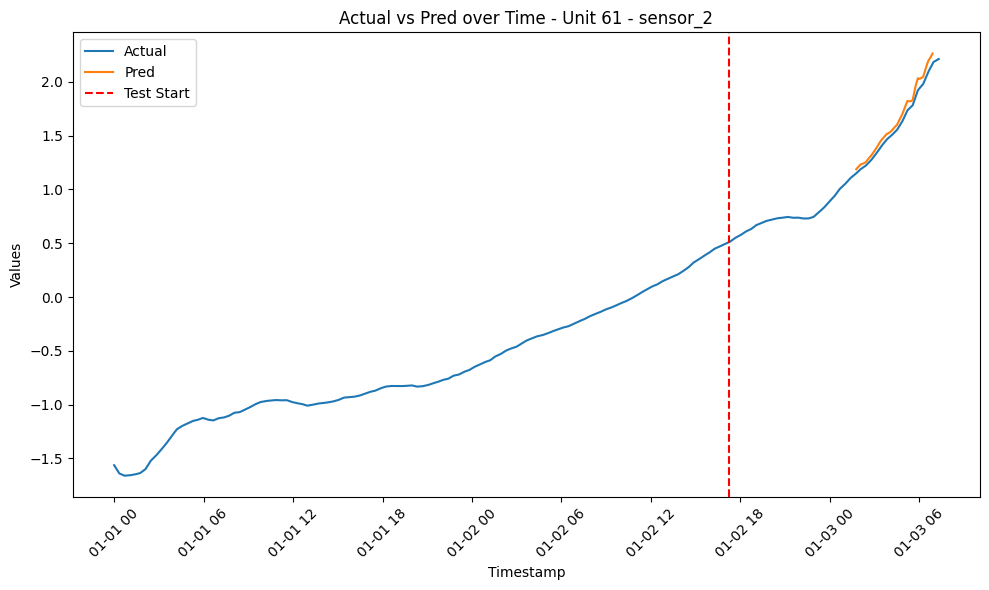

RMSE for Unit 61 - sensor_2: 0.031717919625450494


  0%|          | 0/113 [00:00<?, ?it/s]

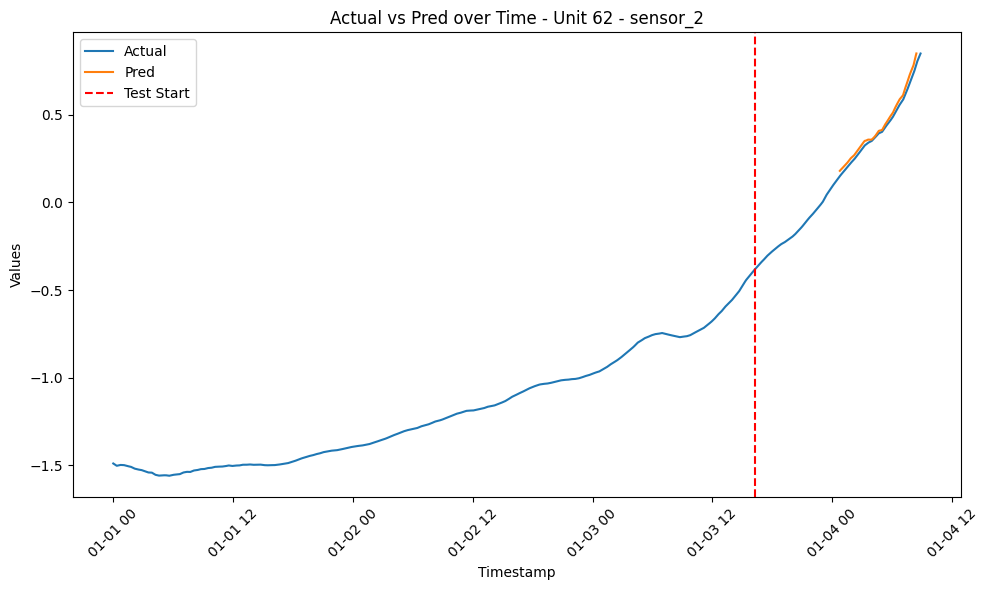

RMSE for Unit 62 - sensor_2: 0.012009874064705642


  0%|          | 0/93 [00:00<?, ?it/s]

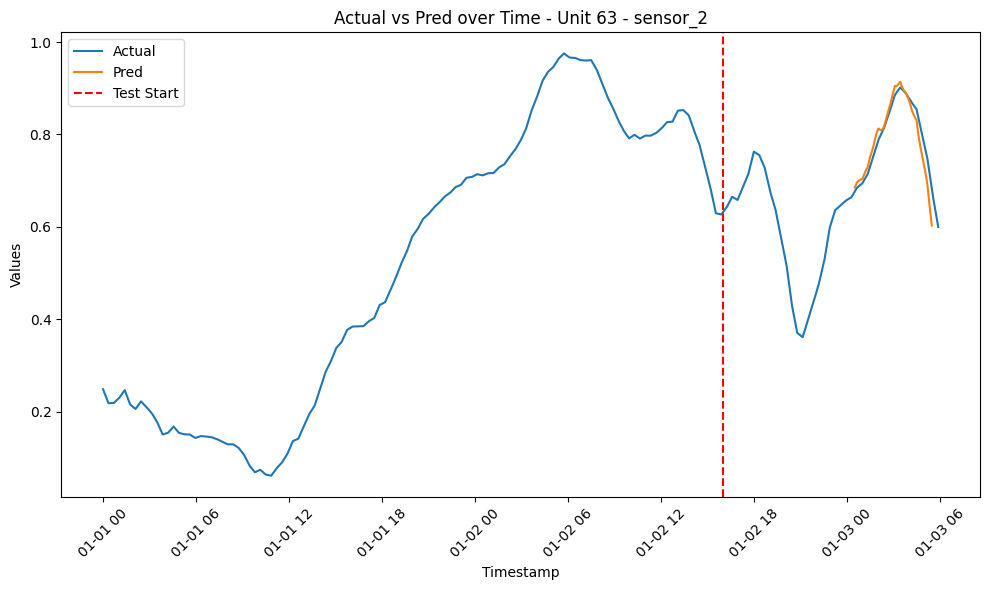

RMSE for Unit 63 - sensor_2: 0.021512324042248464


  0%|          | 0/96 [00:00<?, ?it/s]

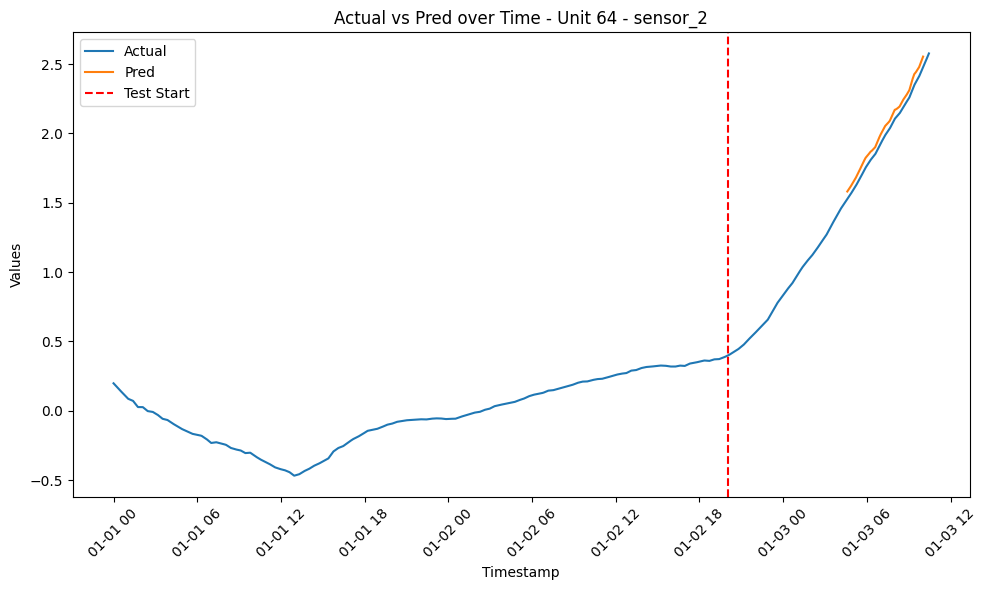

RMSE for Unit 64 - sensor_2: 0.01563879861707368


  0%|          | 0/78 [00:00<?, ?it/s]

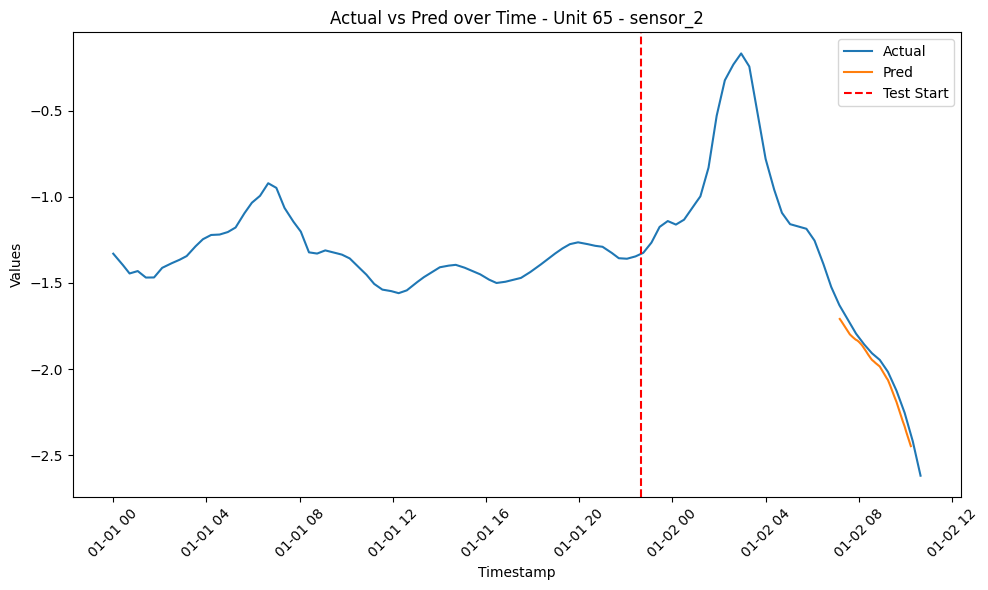

RMSE for Unit 65 - sensor_2: 0.06601375717465789


  0%|          | 0/91 [00:00<?, ?it/s]

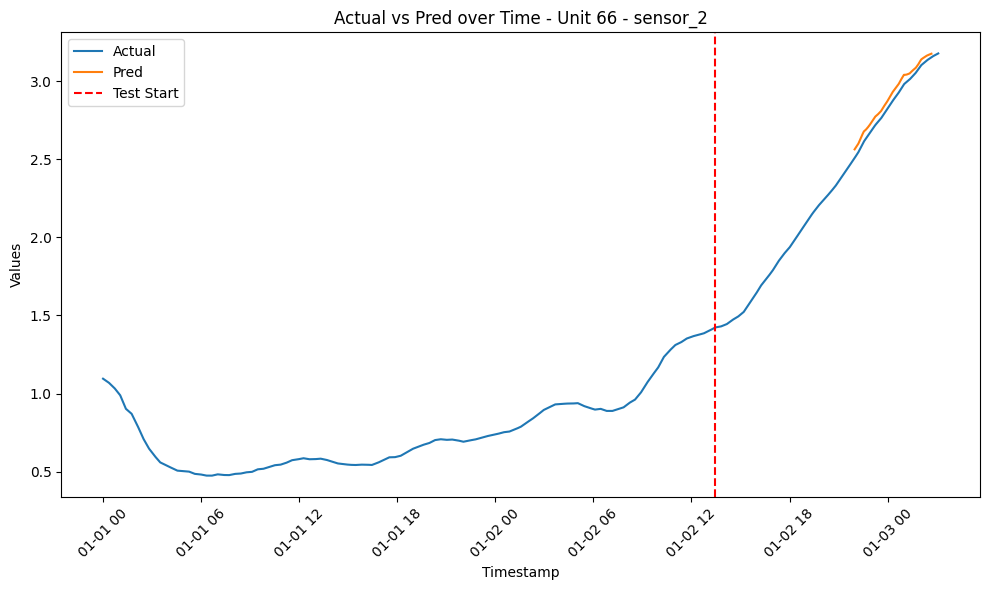

RMSE for Unit 66 - sensor_2: 0.011229444205849003


  0%|          | 0/78 [00:00<?, ?it/s]

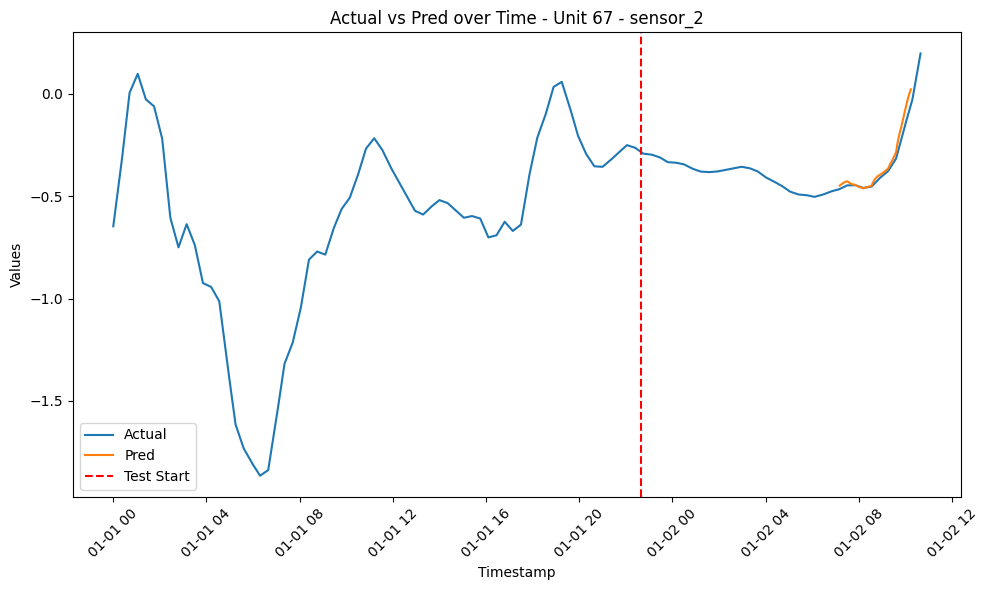

RMSE for Unit 67 - sensor_2: 0.06891037292009745


  0%|          | 0/101 [00:00<?, ?it/s]

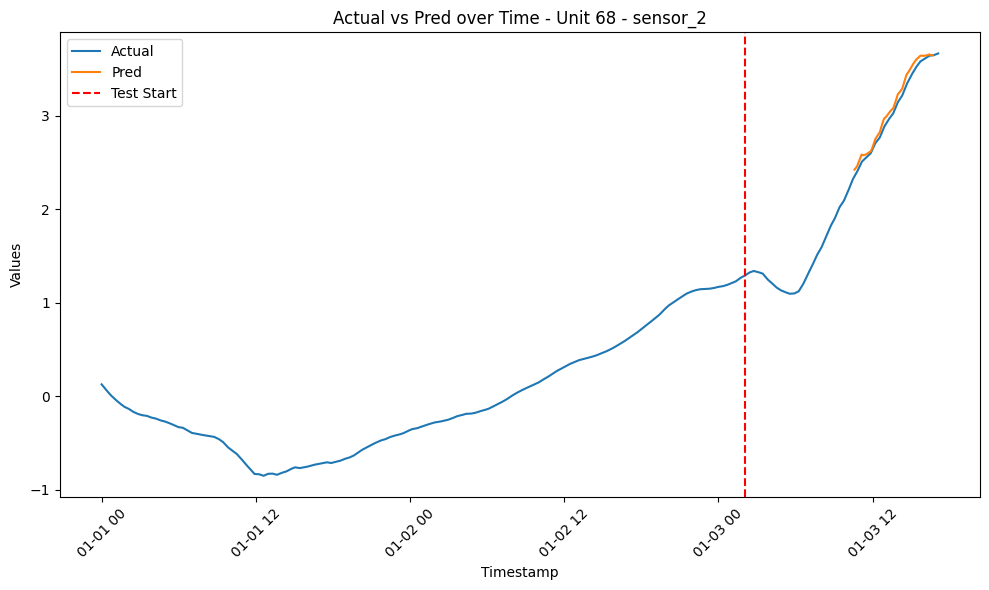

RMSE for Unit 68 - sensor_2: 0.03690614680855875


  0%|          | 0/78 [00:00<?, ?it/s]

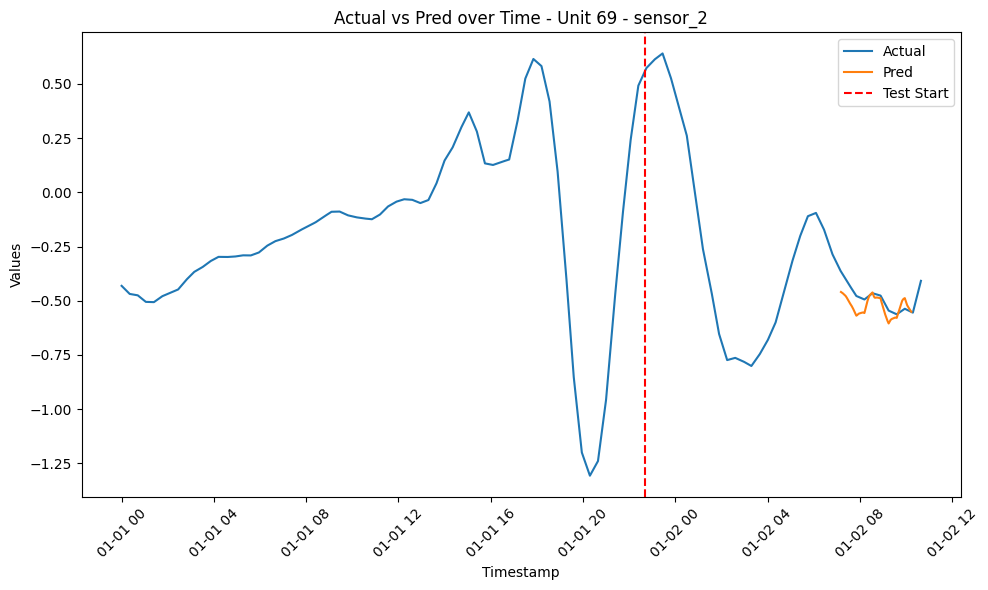

RMSE for Unit 69 - sensor_2: 0.049020405482341066


  0%|          | 0/92 [00:00<?, ?it/s]

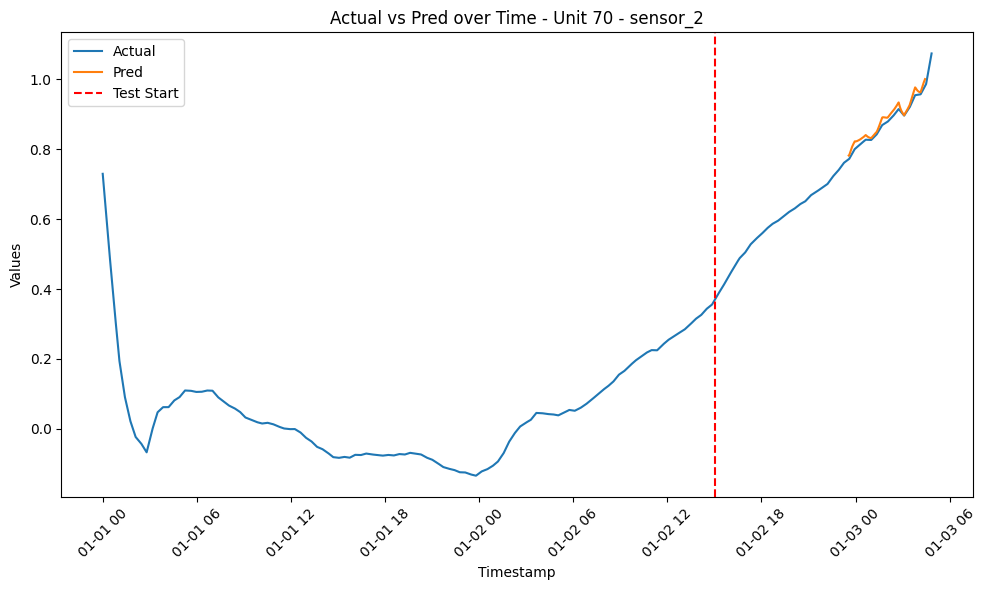

RMSE for Unit 70 - sensor_2: 0.019518325794478972


  0%|          | 0/78 [00:00<?, ?it/s]

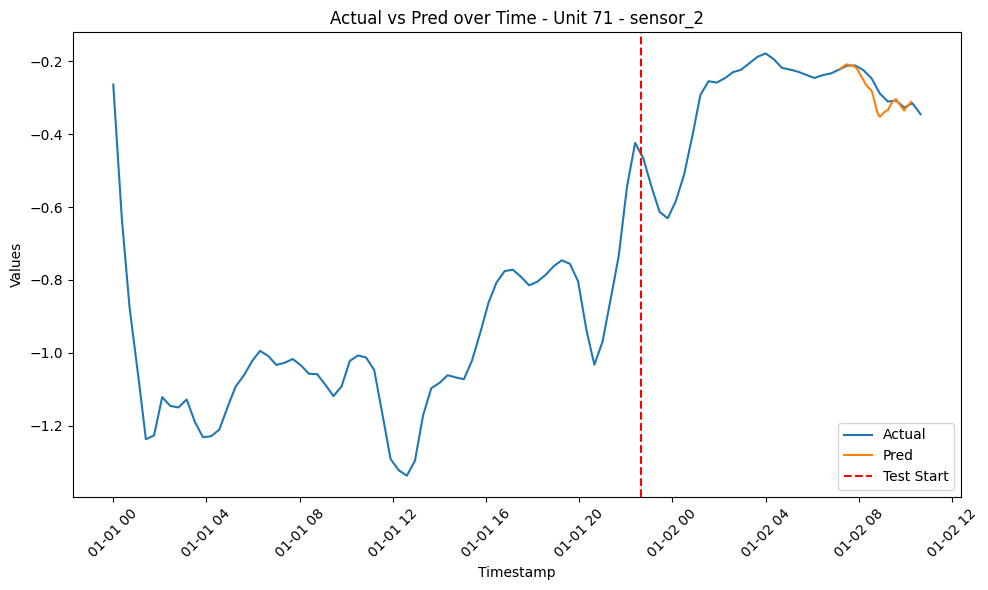

RMSE for Unit 71 - sensor_2: 0.01701290754995823


  0%|          | 0/87 [00:00<?, ?it/s]

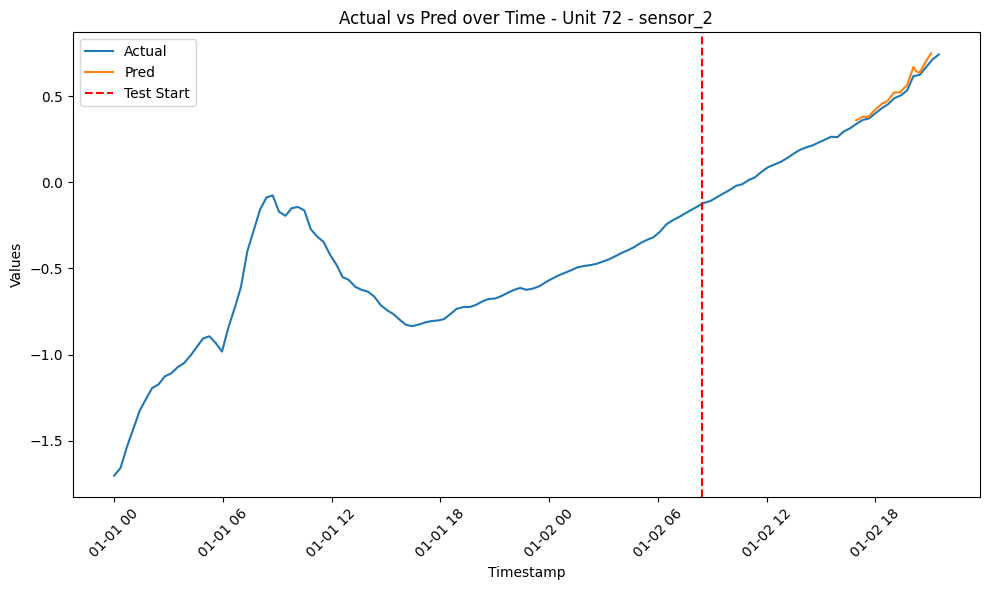

RMSE for Unit 72 - sensor_2: 0.019759301704905047


  0%|          | 0/82 [00:00<?, ?it/s]

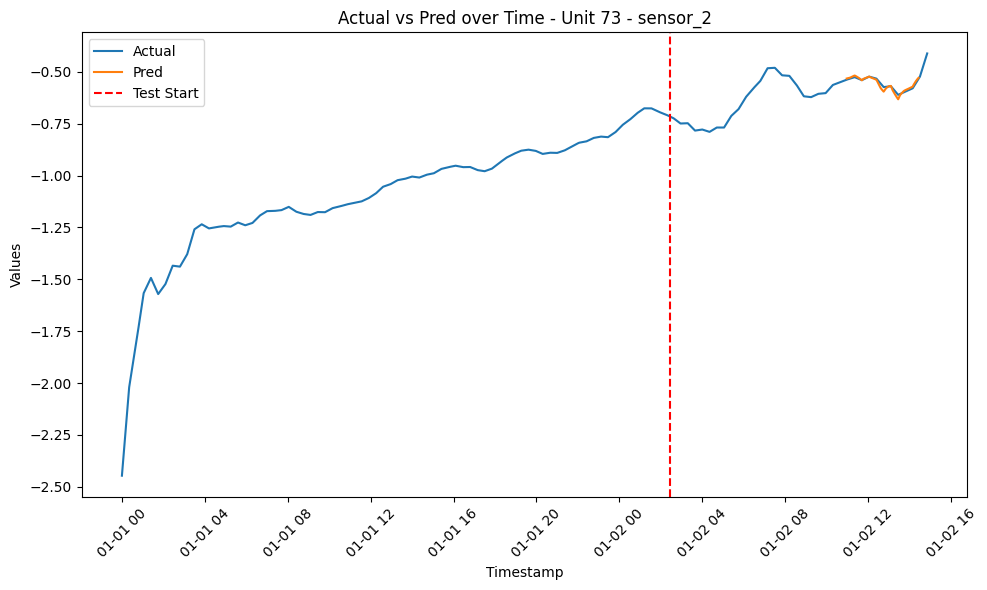

RMSE for Unit 73 - sensor_2: 0.03344478893215258


  0%|          | 0/88 [00:00<?, ?it/s]

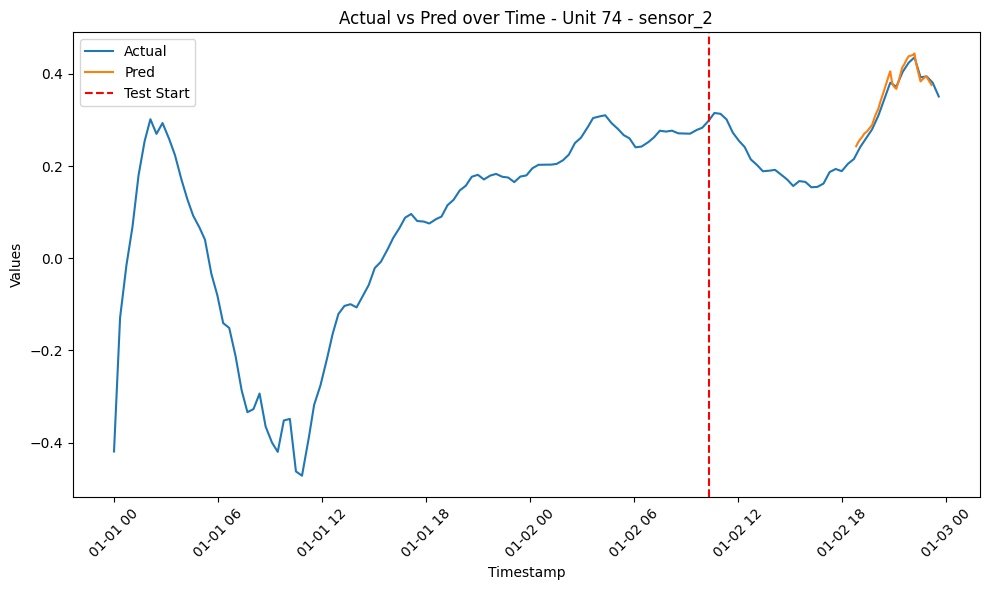

RMSE for Unit 74 - sensor_2: 0.02056445001591209


  0%|          | 0/78 [00:00<?, ?it/s]

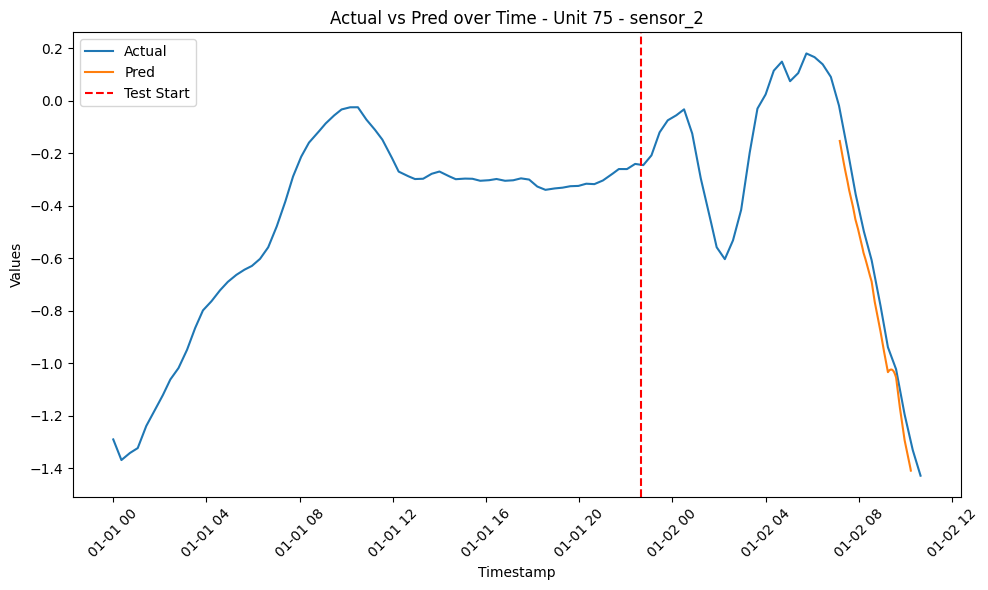

RMSE for Unit 75 - sensor_2: 0.0776835840620069


  0%|          | 0/106 [00:00<?, ?it/s]

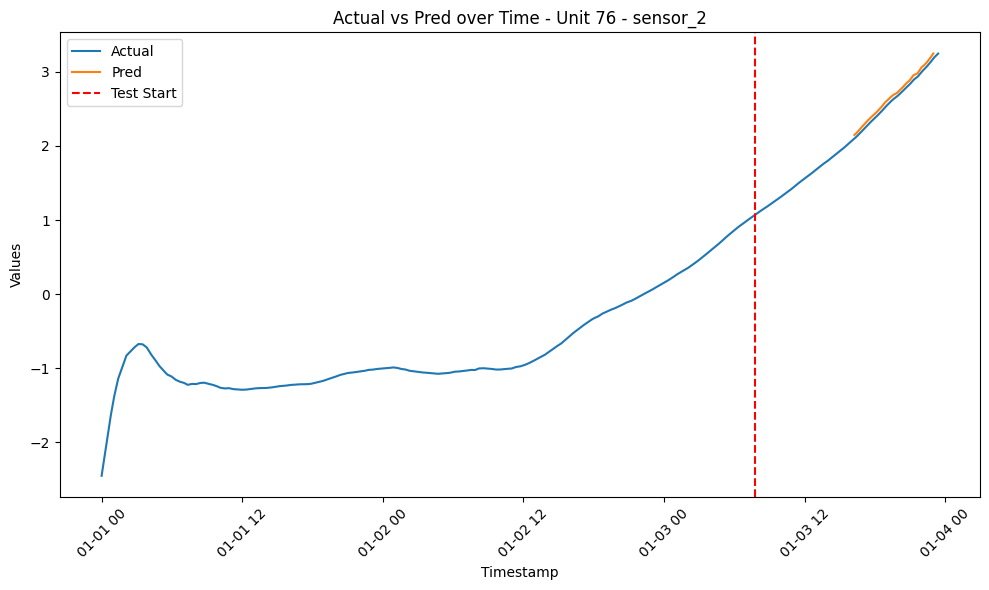

RMSE for Unit 76 - sensor_2: 0.010714299002444841


  0%|          | 0/95 [00:00<?, ?it/s]

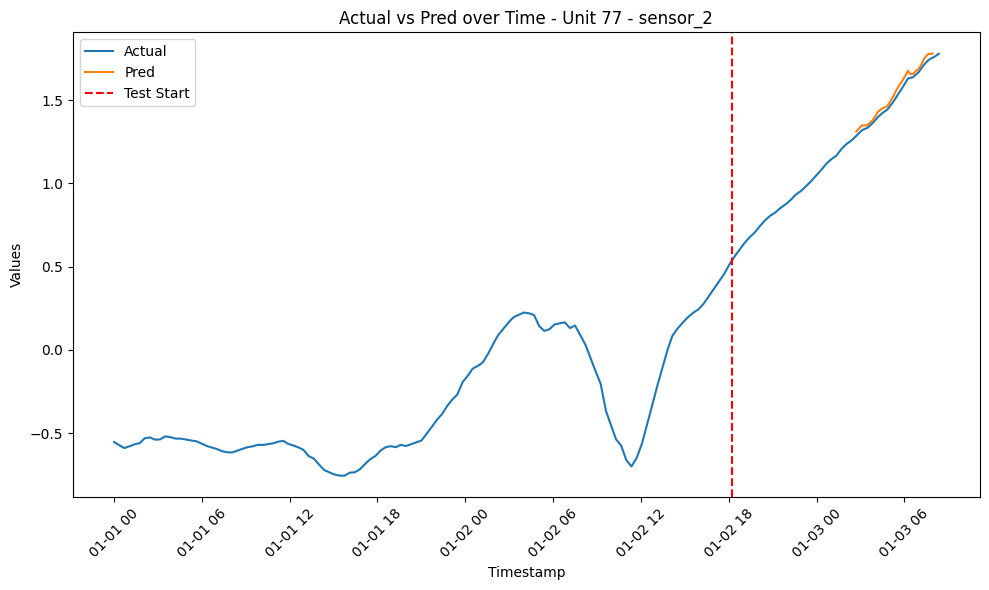

RMSE for Unit 77 - sensor_2: 0.015543576532422596


  0%|          | 0/78 [00:00<?, ?it/s]

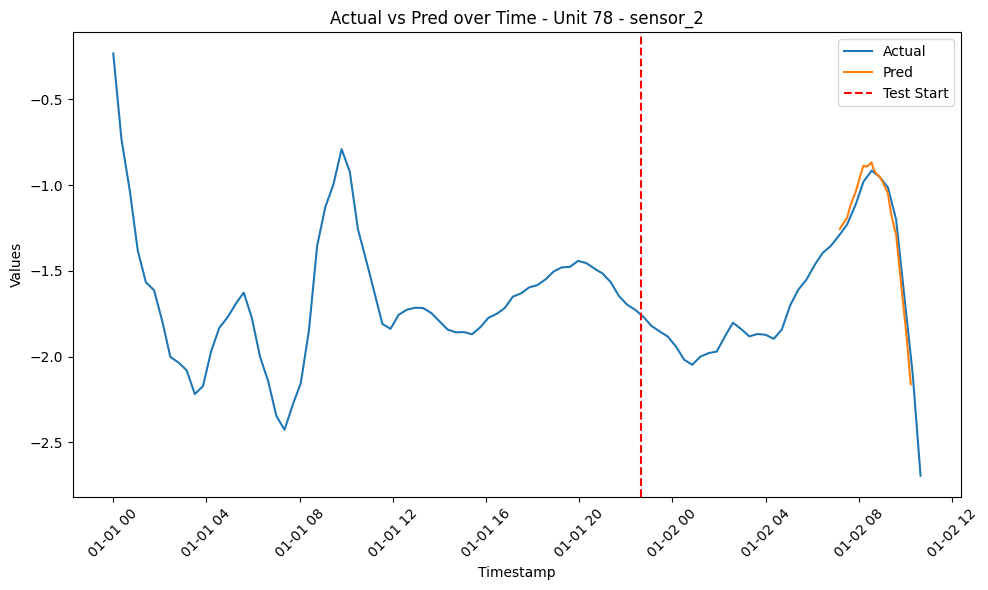

RMSE for Unit 78 - sensor_2: 0.2329467274399965


  0%|          | 0/79 [00:00<?, ?it/s]

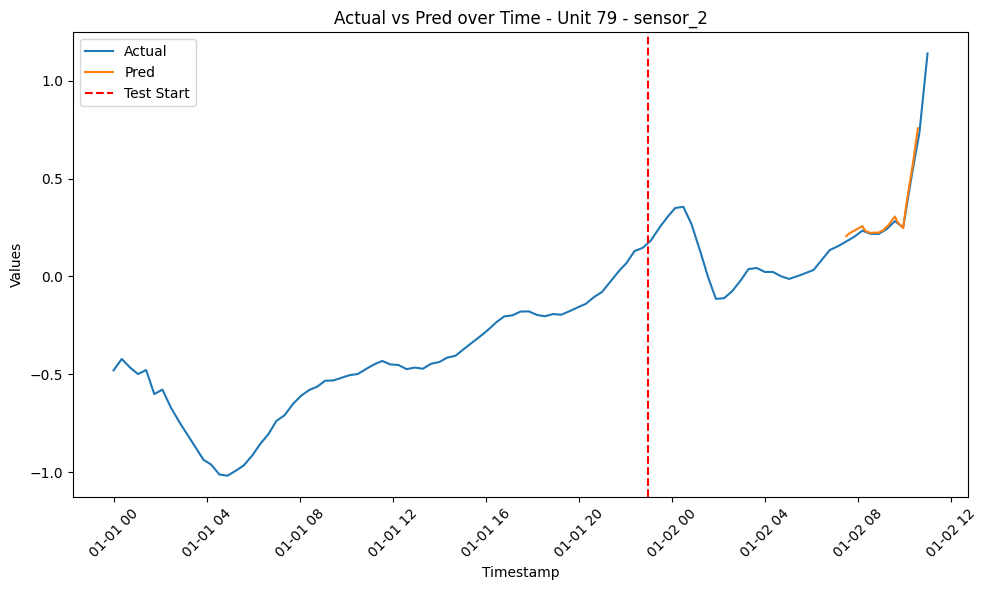

RMSE for Unit 79 - sensor_2: 0.1446118997885055


  0%|          | 0/87 [00:00<?, ?it/s]

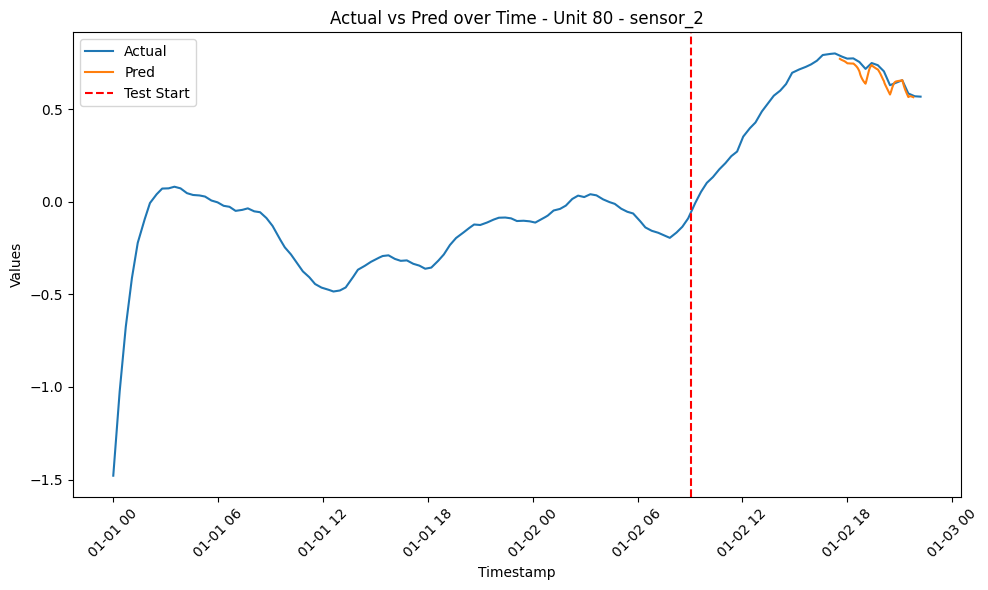

RMSE for Unit 80 - sensor_2: 0.03739052085228334


  0%|          | 0/108 [00:00<?, ?it/s]

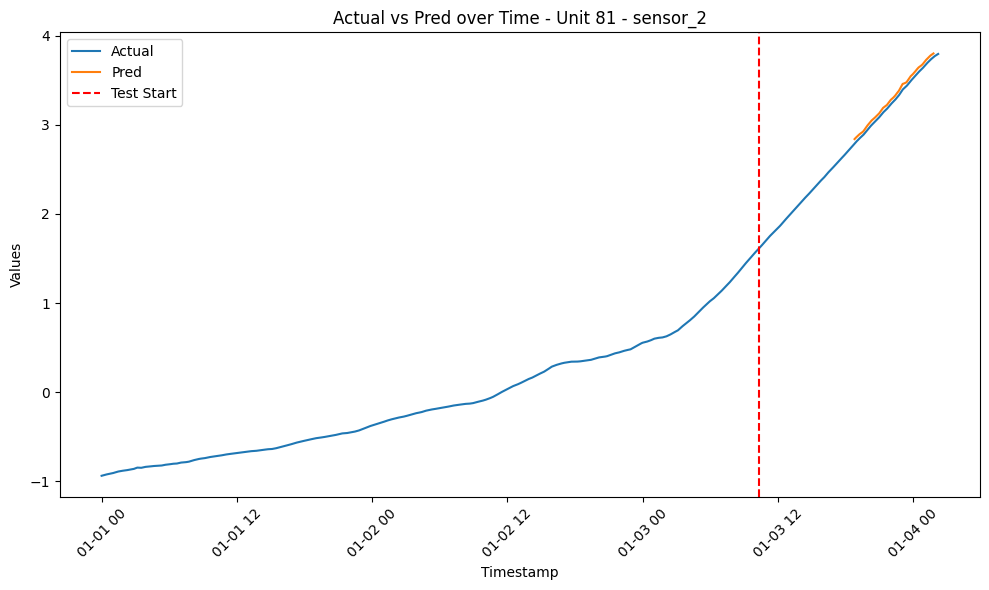

RMSE for Unit 81 - sensor_2: 0.010016089757543077


  0%|          | 0/95 [00:00<?, ?it/s]

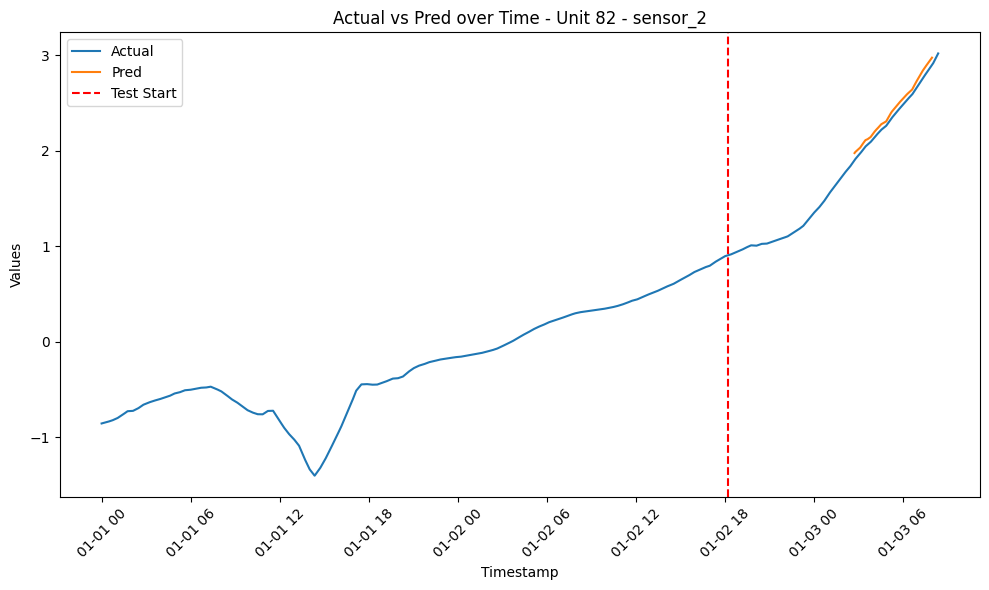

RMSE for Unit 82 - sensor_2: 0.018165032590183438


  0%|          | 0/78 [00:00<?, ?it/s]

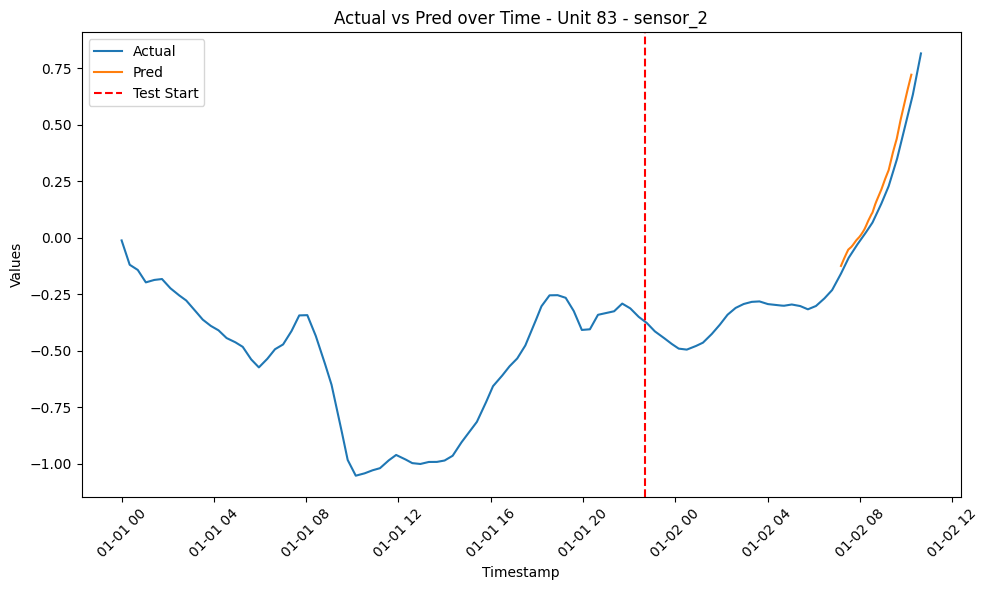

RMSE for Unit 83 - sensor_2: 0.04876048820011828


  0%|          | 0/97 [00:00<?, ?it/s]

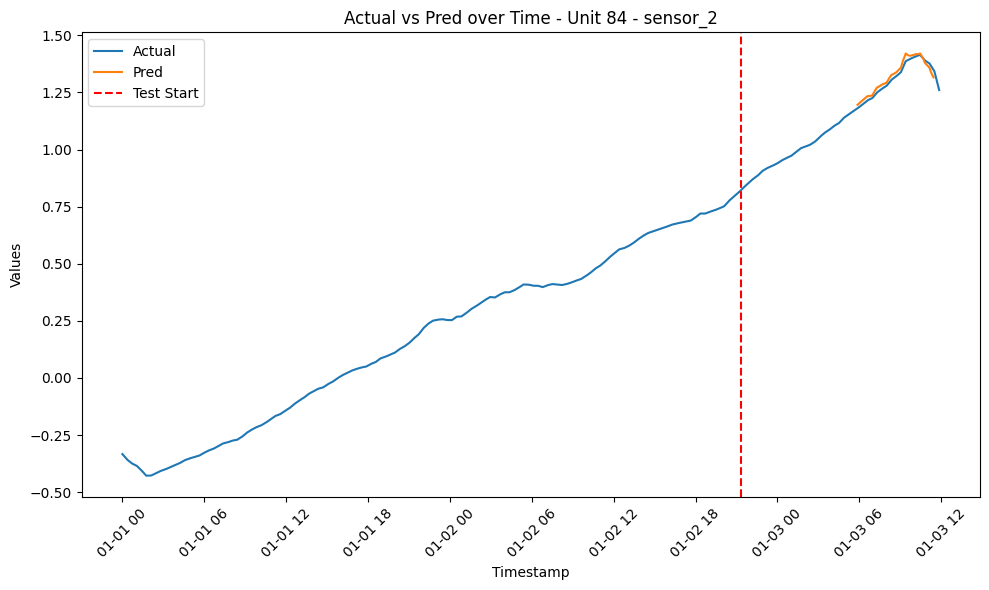

RMSE for Unit 84 - sensor_2: 0.014796453952397898


  0%|          | 0/78 [00:00<?, ?it/s]

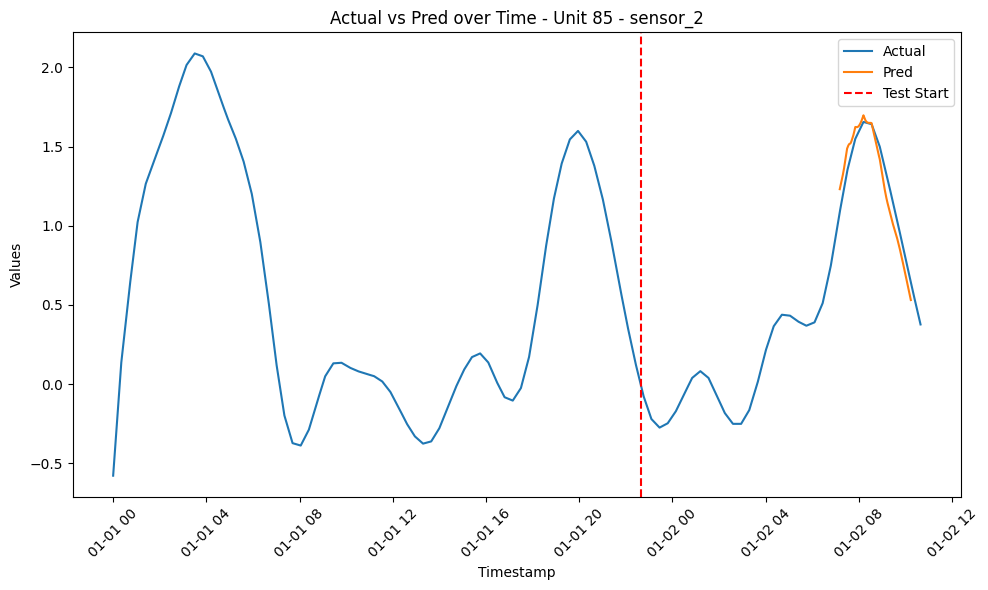

RMSE for Unit 85 - sensor_2: 0.12688473883453483


  0%|          | 0/81 [00:00<?, ?it/s]

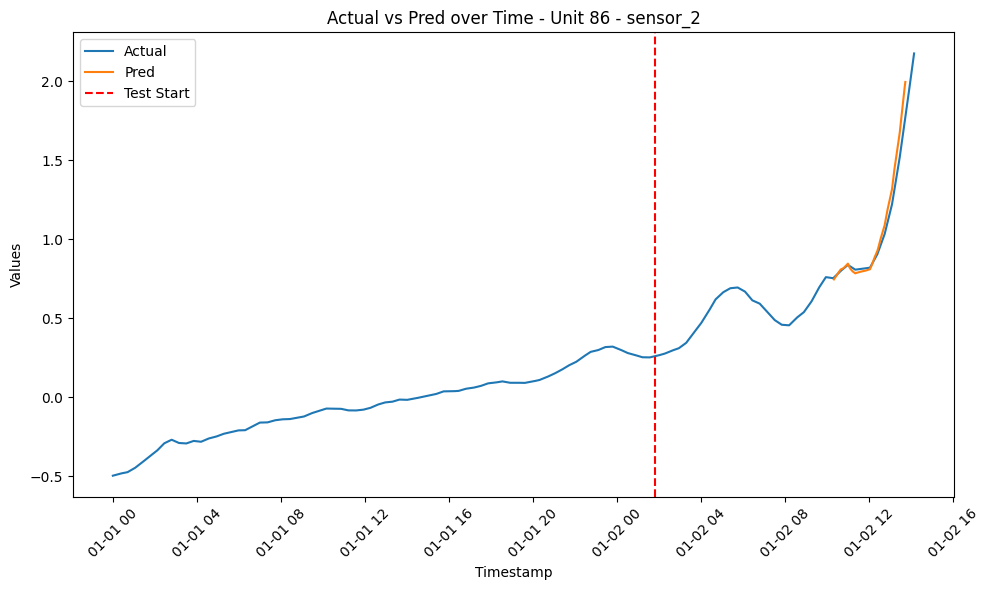

RMSE for Unit 86 - sensor_2: 0.12895649839106338


  0%|          | 0/78 [00:00<?, ?it/s]

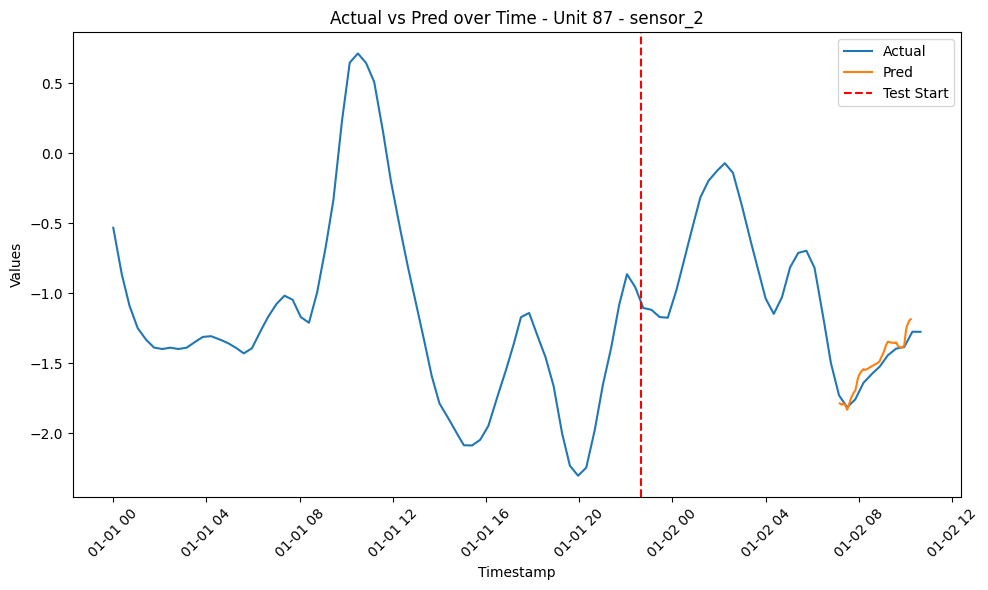

RMSE for Unit 87 - sensor_2: 0.04711220630000615


  0%|          | 0/78 [00:00<?, ?it/s]

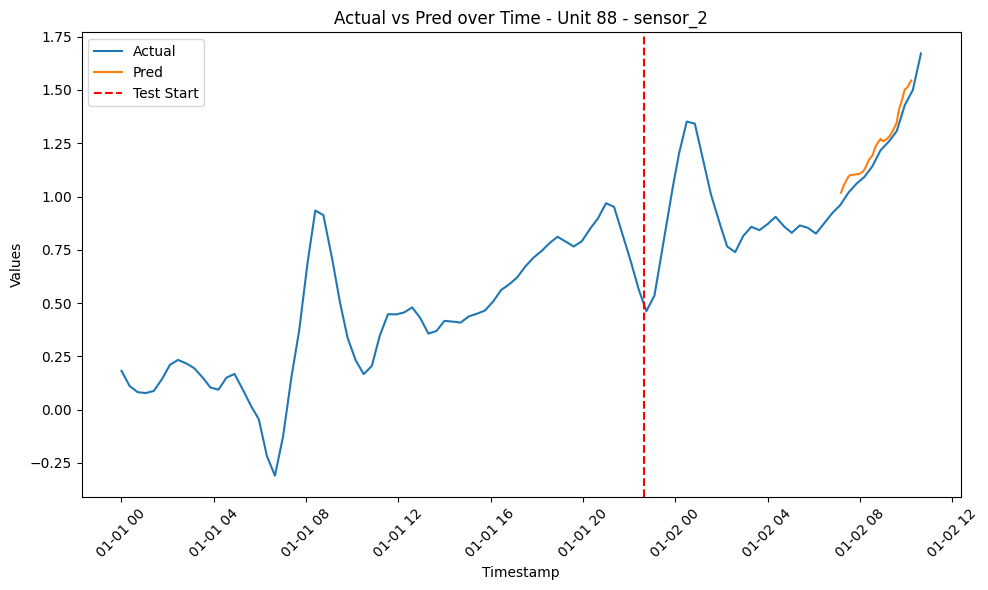

RMSE for Unit 88 - sensor_2: 0.04263123896134839


  0%|          | 0/99 [00:00<?, ?it/s]

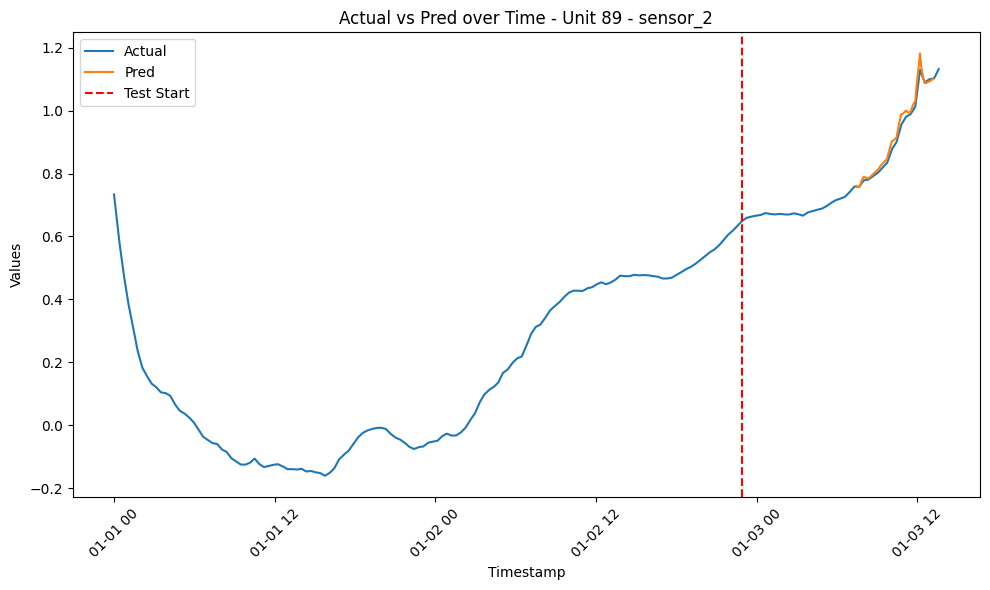

RMSE for Unit 89 - sensor_2: 0.02847949566721375


  0%|          | 0/91 [00:00<?, ?it/s]

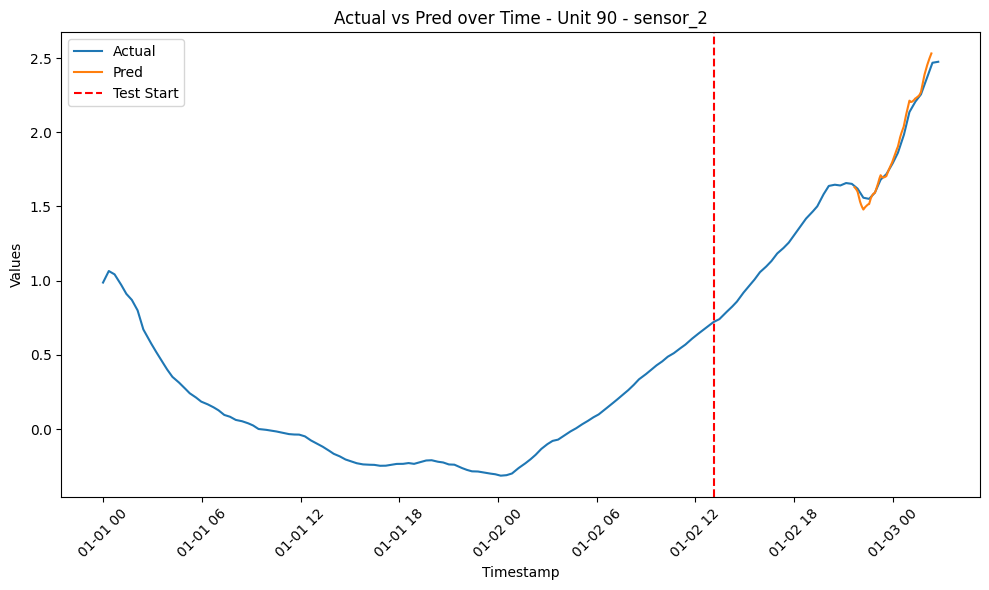

RMSE for Unit 90 - sensor_2: 0.06924495302523698


  0%|          | 0/114 [00:00<?, ?it/s]

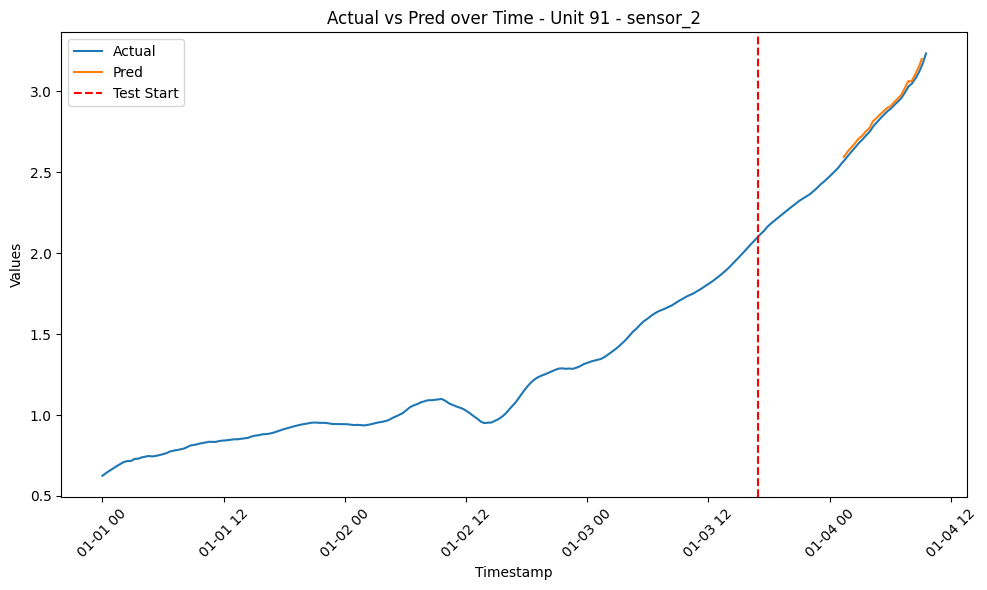

RMSE for Unit 91 - sensor_2: 0.009732083244101875


  0%|          | 0/92 [00:00<?, ?it/s]

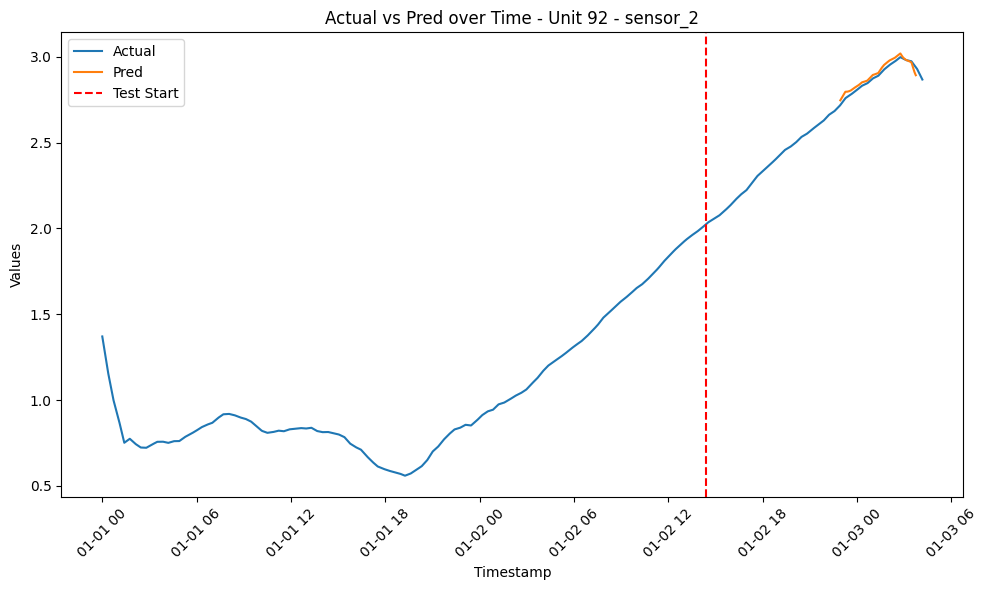

RMSE for Unit 92 - sensor_2: 0.0160404560907901


  0%|          | 0/116 [00:00<?, ?it/s]

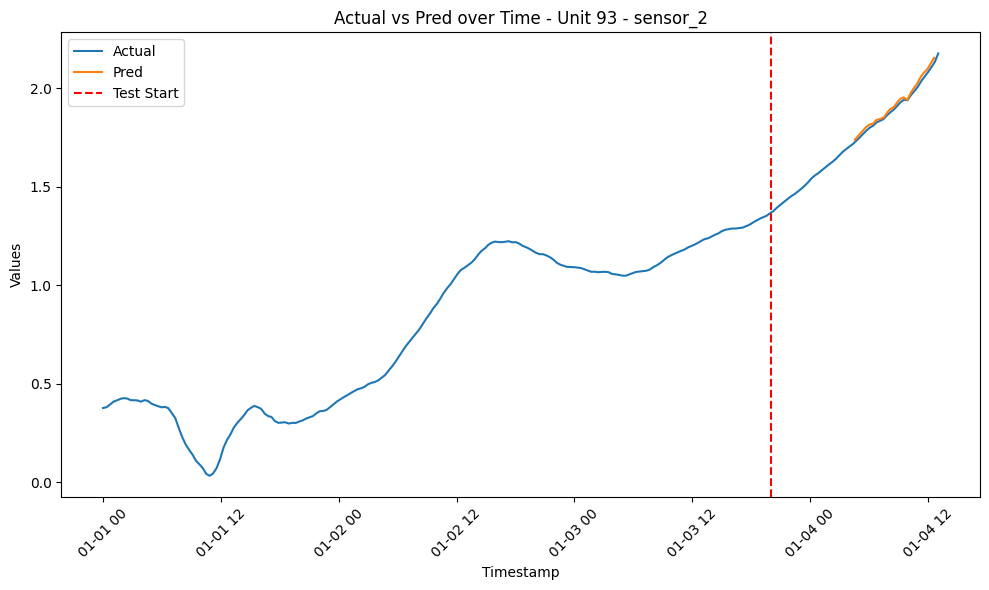

RMSE for Unit 93 - sensor_2: 0.008273073580709235


  0%|          | 0/87 [00:00<?, ?it/s]

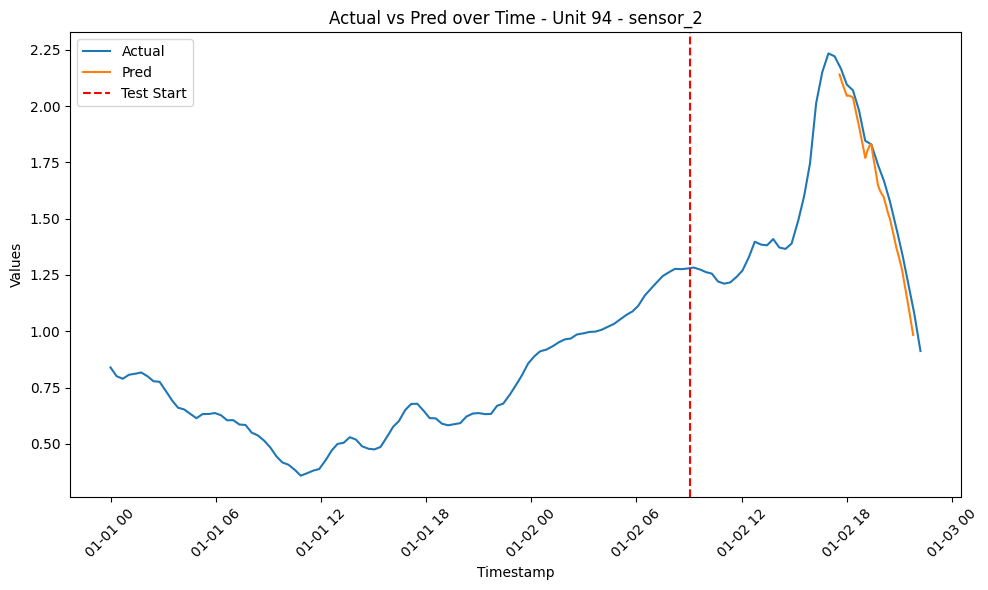

RMSE for Unit 94 - sensor_2: 0.05166481653651831


  0%|          | 0/78 [00:00<?, ?it/s]

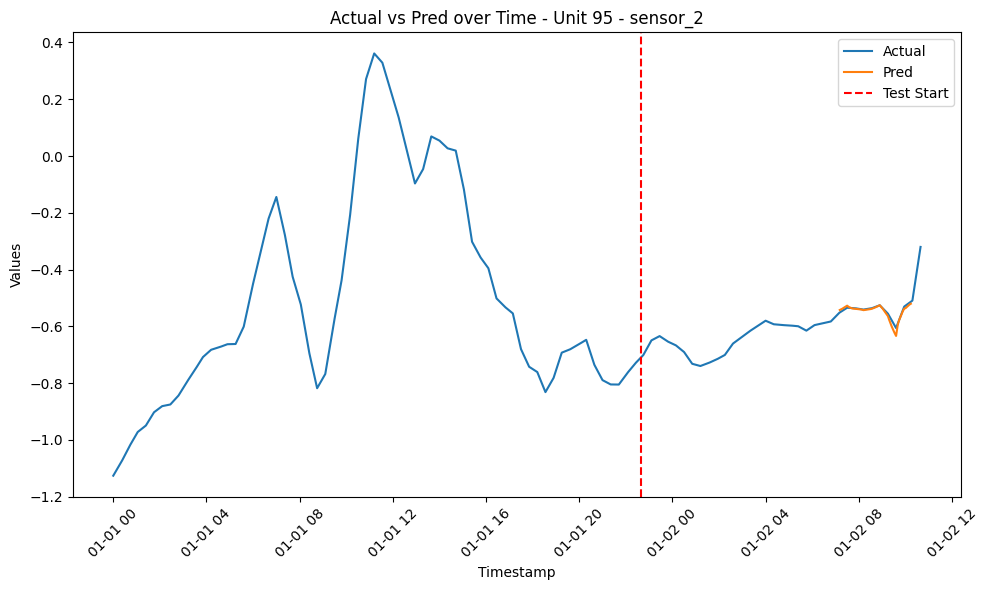

RMSE for Unit 95 - sensor_2: 0.052484258199190885


  0%|          | 0/78 [00:00<?, ?it/s]

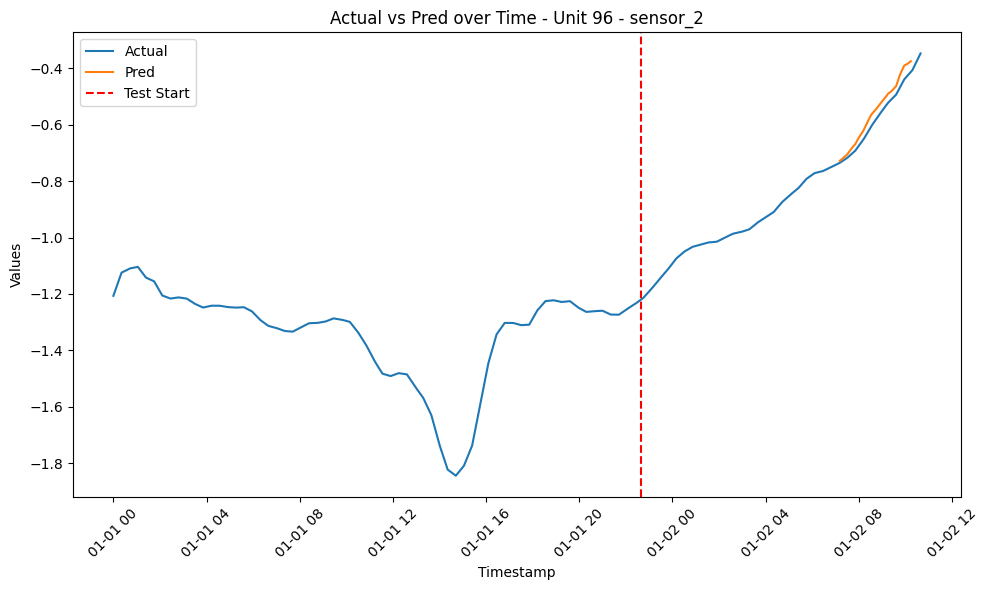

RMSE for Unit 96 - sensor_2: 0.0160762979851619


  0%|          | 0/87 [00:00<?, ?it/s]

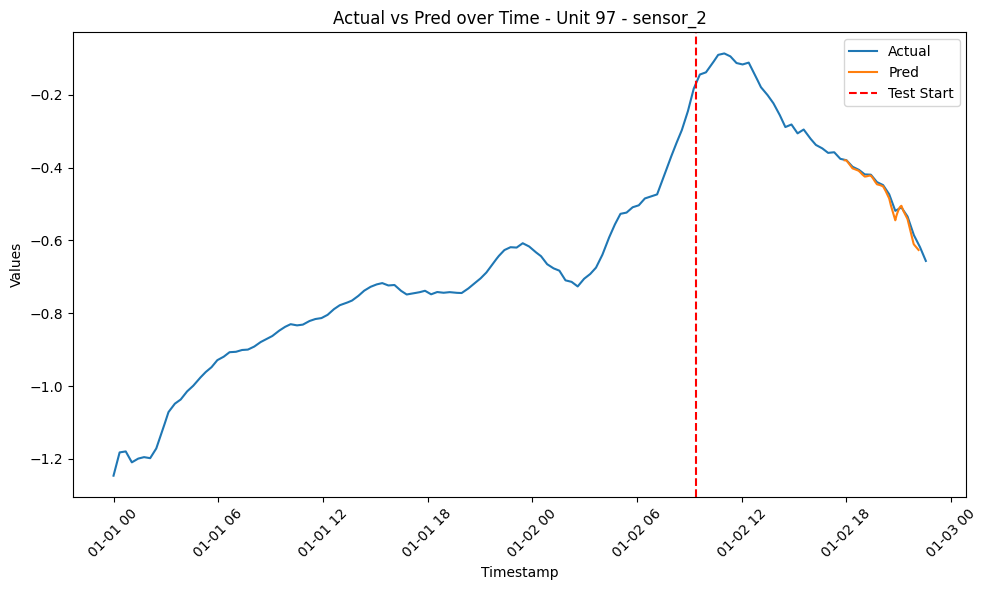

RMSE for Unit 97 - sensor_2: 0.0222338364949775


  0%|          | 0/84 [00:00<?, ?it/s]

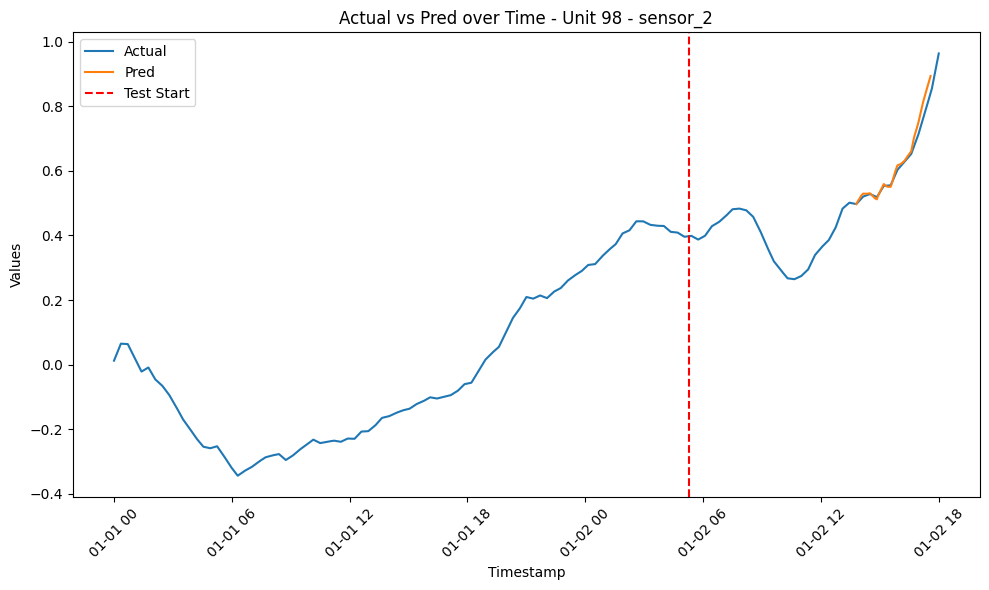

RMSE for Unit 98 - sensor_2: 0.033861034328010686


  0%|          | 0/78 [00:00<?, ?it/s]

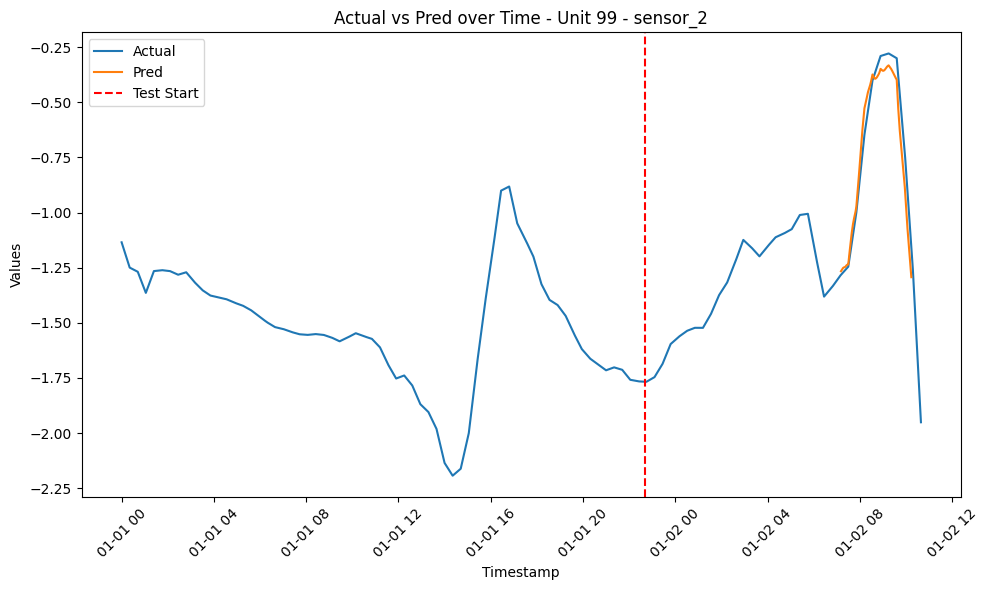

RMSE for Unit 99 - sensor_2: 0.2802606867657982


  0%|          | 0/104 [00:00<?, ?it/s]

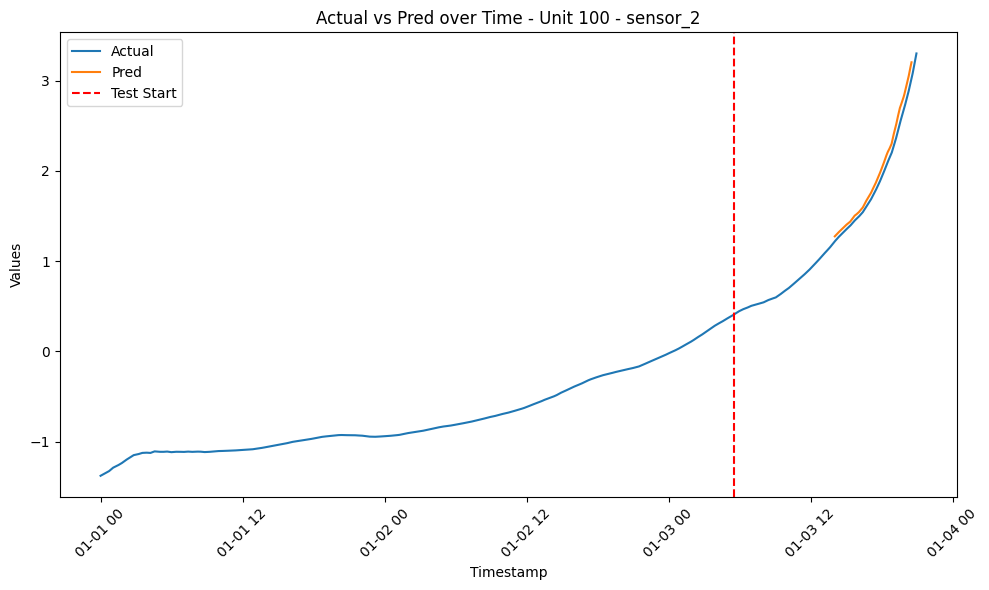

RMSE for Unit 100 - sensor_2: 0.03537587499942371


In [627]:
# Forecast each unit's RUL
# Assuming the necessary variables (e.g., train_df, context_length, tsp, timestamp_column, target_columns) are defined

unit_list = []
rmse_list = []
split_configs = generate_split_configs(train_df, context_length)

for unit in train_df['unit_number'].unique():
    unit = int(unit)
    df_subset = train_df[train_df['unit_number'] == unit]
    df_subset = df_subset.reset_index(drop=True)
    split_config = split_configs[unit - 1]  # Access by index

    '''
    # Run data checks for debug
    print(split_config)
    print(len(df_subset))
    if df_subset is None or len(df_subset) == 0:
        print(f"No data available for unit {unit}")
    else:
        print(f"Dataset for unit {unit} is good")
    '''

    # Reset Preprocessor
    tsp = TimeSeriesPreprocessor(
      **column_specifiers,
      context_length=context_length,
      prediction_length=forecast_length,
      scaling=False,
      encode_categorical=True,
      scaler_type="standard",
    )
    
    # Generate datasets based on the split configuration
    #train_dataset, valid_dataset, test_dataset = get_datasets(tsp, dataset=df_subset, split_config=split_config, fewshot_fraction=fewshot_fraction)
    train_dataset, valid_dataset, test_dataset = get_datasets(tsp, dataset=df_subset, split_config=split_config)
    
    # Assign the zeroshot model
    zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision="main", prediction_filter_length=prediction_filter)

    # Initialize trainer with the model
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
    )

    # Evaluate the model on the test dataset
    zeroshot_trainer.evaluate(test_dataset)

    # Create a forecasting pipeline
    zs_forecast_pipeline = TimeSeriesForecastingPipeline(
        model=zeroshot_model,
        device="cpu",
        timestamp_column=timestamp_column,
        id_columns=[],  # Adjust id_columns if needed
        target_columns=target_columns,
        freq="1m"
    )

    # Retrieve test data start and end indices
    test_start_index, test_end_index = split_config['test']

    # Generate forecast
    processed_data = tsp.preprocess(df_subset[test_start_index:test_end_index])
    zs_forecast = zs_forecast_pipeline(processed_data)

    # Compare forecast with actual data and prepare for plotting
    df = compare_forecast(zs_forecast, "timestamp", "sensor_2_prediction", "sensor_2", prediction_filter)
    df.dropna(inplace=True)

    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(df_subset['timestamp'], df_subset[target_columns], label='Actual', linestyle='-')
    plt.plot(df['timestamp'], df['pred'], label='Pred', linestyle='-')

    # Add labels and legend
    plt.axvline(x=df_subset['timestamp'].iloc[test_start_index], color='red', linestyle='--', label='Test Start')
    plt.xlabel('Timestamp')
    plt.ylabel('Values')
    plt.title('Actual vs Pred over Time - Unit ' + str(unit) + ' - ' + target_columns[0])
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Calculate RMSE for the unit
    rmse = np.sqrt(mean_squared_error(df['actual'], df['pred']))
    print(f"RMSE for Unit {unit} - {target_columns[0]}: {rmse}")
    unit_list.append(unit)
    rmse_list.append(rmse)
    #print("======================================================")
    

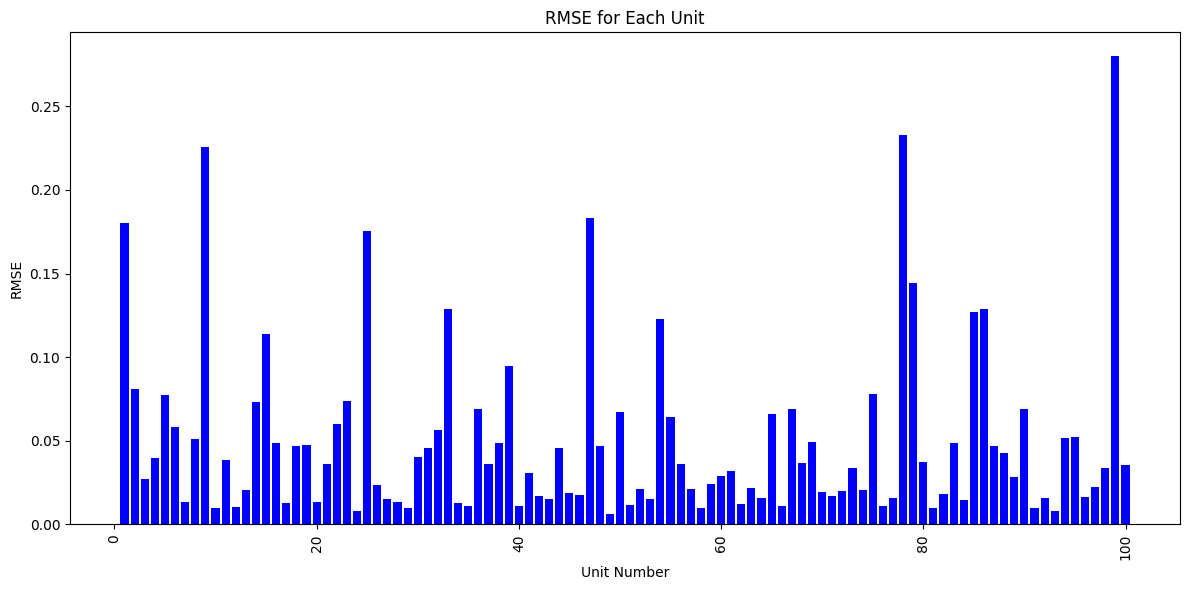

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(unit_list, rmse_list, color='blue')
plt.xlabel('Unit Number')
plt.ylabel('RMSE')
plt.title('RMSE for Each Unit - Sensor 2')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()